# BIOMEDIN 260/RAD260: Problem Set 1 - Segmentation

## Spring 2020

## Yiheng Li

## iPython Notebooks: A lesson in reproducibility

For those of you that are unfamiliar, iPython notebooks are interactive Python sessions that allow you to intersperse code, raw text, and markdown in a seamless manner. The next paragraph will teach you to use them.

The words you are reading right now are modifiable. Double-click me to change the text that you're reading. These modifiable boxes are called cells. They will be used to write answers to our written questions. 

Double-click the box above me now, and go ahead and fill in your name (and your partner's as well, if applicable).

Cells can contain executable code as well. If you're running the Jupyter Notebook program, You can change the type of cell by highlighting the cell of interest and going to `Cell -> Cell Type -> Markdown/Code`, and then clicking the desired cell type. If you're running the newer JupyterLab program, just click the drop-down menu next to the play, stop, and refresh icons above this window (along the top of the tabs detailing the current files that are open) and change the cell type directly there. 

You can add cells using Insert in the Jupyter Notebook program and the `'+'` icon in JupyterLab. 

The best thing about notebooks is that you can run small components of your code in one cell to make sure they work before putting them together to make a larger component. Make as many cells as you want to play and experiment, but please delete them if they are not part of your final submission. To delete a cell, highlight the cell and going to `Edit -> Delete Cells`, or use the keyboard shortcut of pressing the 'D' button twice. Make sure to not do this by mistake, but if you do, you can `"Redo Cell Operation"` from the respective menus in the different programs.

Another nice thing about notebooks - the entire homework assignment is self-contained in this file! Please put all your functions and classes into the cells of this notebook, and please write clean code with at least some annotation to help us follow your thought process. Once you're done, export the notebook to a `.pdf` file and submit on Canvas.

In research, it is important that code is readable and reproducible. Notebooks are a natural first step toward both goals.

# Setup

Run the code in the following cells by single clicking on them and then press CTRL+ENTER (SHIFT+ENTER on Mac) or click the play button in the menu bar (the one to the left of the stop button and to the right of the up and down arrows).

The following first cell loads all the Python dependencies for this homework. It's OK if you get an error at first.

In [1]:
import os
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import skimage

In [2]:
%matplotlib inline

In [3]:
# Extra packages (due to some funny error of scikit-image)
from skimage.filters import threshold_otsu
from scipy.ndimage import label, center_of_mass
from skimage.morphology import binary_closing

# The Data

We will be using data from the recent (2017) Kaggle Data Bowl challenge in this homework. You can download their data
freely from [Kaggle](https://www.kaggle.com/c/data-science-bowl-2017) or [here](https://drive.google.com/file/d/1XGQ5gy3gRFRxSMMvZVDb1cqyhX4pdql7/view?usp=sharing). I highly recommend downloading the “`sample images.7z`” file as this’ll give you full CT scans, but won’t take a day to download (total size < 1 GB).

**Please download and unzip the data folder as soon as possible. Even the file for just the sample data is pretty big, coming in at ∼800 MB. You need the data to do the assignment. We will not accept your homework using any other data. Please try to download the data as soon as possible, and contact the TAs if you run into any problems. Do not wait until the last minute to download the data!**

The data consist of sets of DICOM images that hold completely anonymized chest CT scans (see section “Reading in the Data”). DICOM (Digital Imaging and Communications in Medicine) is a standardized format for transmitting medical image data. Each DICOM file is composed of two parts: the image data as well as a header giving you a lot of metadata about the patient and specifics about the imaging parameters (e.g. space between slices).

You can choose any of the patients in the Kaggle dataset (sample, training, or validation) to prototype your code, but we expect you to generalize your algorithm to work for at least ten different patients to show robustness. The more you do, the more you’ll prove your algorithm.

First, let's make sure you can read in the data.

In the cell below, replace the `scans_path` string variable with the (relative or absolute) path to the place where you put the data. Particularly, look for the folder that contains scans. Each scan is in its own folder and has a name, e.g. 0a0c32c9e08cc2ea76a71649de56be6d. `scans_path` should be the folder that contains these oddly named folders. Once you do this, you can run the cell below to look at all the metadata associated with that slice.

It should look like this:

<img src = "figures/dicom_fields.png">

In [4]:
# each chest CT scan is a folder with a long weird name like 0a0c32c9e08cc2ea76a71649de56be6d that within contains
# many .dcm files with similar long weird names, assign the path to such folder to the variable scans_path 

scans_path = "/Users/terryli/Codes/BIOMEDIN260/CT_chest_scans" # TODO: Change this to match where your data is located!
list_of_scans = os.listdir(scans_path)

# for figuring out the controls lets experiment with slice 122 of slice 2
scan_num = 2
scan_path = os.path.join(scans_path,list_of_scans[scan_num])
list_of_slices = os.listdir(scan_path)
slice_num = 122
slice_path = os.path.join(scan_path,list_of_slices[slice_num])

# read in the full path to the file as ds
ds=dicom.read_file(slice_path) # you may have to use pydicom instead of dicom 
print(ds)

(0008, 0000) Group Length                        UL: 348
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.167025016941396632973794512500
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0000) Group Length                        UL: 64
(0010, 0010) Patient's Name                      PN: '0b20184e0cd497028bdd155d9fb42dc9'
(0010, 0020) Patient ID                          LO: '0b20184e0cd497028bdd155d9fb42dc9'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: None
(0020, 0000) Group Length                        UL: 332
(0020, 000d) Study Instance UID                  UI: 2.25.12959879976443571621843145901999710656652277064659217139009
(0020, 000e) Series Instance UID         

## That's a lot of metadata, right? Don't be scared. Next, let's actually look at the slice.

We can see that there are many data fields in a DICOM file. There's a lot of patient information stored in a DICOM - name, birthdate, and so on. For obvious privacy reasons, this data has been completely anonymized. It’s pretty evident that our data probably didn’t come from Mr./Mrs. 0a0c32c9e08cc2ea76a71649de56be6d who was born on January 1st, 1900. 

Run the following cell to view the image associated with this very old man/woman.

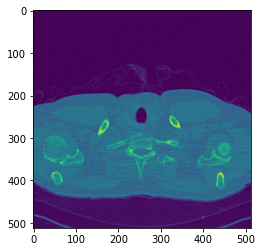

<class 'numpy.ndarray'> 510.1350212097168 uint16


In [5]:
rawimg= ds.pixel_array
plt.imshow(rawimg, cmap='viridis')
plt.show()
print(type(rawimg), np.mean(ds.pixel_array), rawimg.dtype)

We're all set. On to the problem set!

# Introduction

Segmentation is the process of dividing a given image into sections. This can be binary segmentation (if you wanted to separate the image into foreground and background) or a multilabel segmentation if you wanted to label many different parts of an image (see figures below for examples of each). Segmentation is an extremely interesting problem in image analysis, and it has yet to be solved perfectly. From an algorithmic point of view, we can approach the problem using tools such as graph cuts, watershed, flood fill / region growing, statistical set separation, etc... From a machine learning point of view, we can think of the problem as a pixel classification problem that can be solved with some supervised learning algorithm (assuming we had some ground truth training data) or an unsupervised learning algorithm (such as k-means clustering).

<img src = "figures/segmentation0.jpg" >

(a) Binary Segmentation - A binary segmentation of some grains of rice. We can use segmentation to create a binary mask that allows us to separate the rice (foreground) from the darker background. 

<img src = "figures/segmentation1.jpg" >

(b) Multilabel Segmentation - A multilabel segmentation of a coronal section from a magnetic resonance image of the brain. We can see that different colors represent different sections of the brain. For example, the white matter on the left side of the brain is labeled with a different color than the white matter on the right side of the brain. 

A lot of radiological image analysis begins with segmentation. For example, to quantitatively describe a lung nodule, you may want to collect data on its edge sharpness, its total volume, and/or the mean intensity of voxels in the nodule. However, to do this, we have to first be able to segment the nodule and cleanly define its boundaries. This can get extremely hairy. For example, in the chest, it might be hard to teach a program to segment a nodule in the lung from a seed voxel. It's important to make sure the nodule segmentation doesn’t bleed into the pericardium, as the voxel intensities for a nodule and the fleshy bits in the pericardium are very similar. We can try and restrict this through lung field segmentation (basically, we want to go through our chest CT scans and segment out the lungs) and thus define a region of interest, but this gets increasingly difficult as more and more problems pop up.

This assignment will help you understand many core concepts taught in the lectures and hopefully
integrate the lectures into a medically relevant application. The goals of this project include:

a. Understanding medical image data format - specifically, DICOM.

b. Understanding thresholding techniques - specifically, Otsu’s Threshold.

c. Understanding morphological image analysis techniques, and expanding this understanding into 3D.

d. Understanding image convolution and expanding it into efficient 3D.

e. Understanding visualization in 3D.

f. Embracing creativity and exploring image analysis.

These can seem daunting tasks for a first timer, but we promise the final results will be amazingly cool! Stick with us, and as always, don't hesitate to ask for help.

**The main goal of this assignment is to segment out the lungs, and only the lungs, from these CT slices, and then create a 3D rendering of the lungs to give yourself some way to qualitatively assess how good your segmentation is. Basically, given a chest CT series, you will be creating something like this:**

<img src = "figures/lung_field_segmentation.png" >

# Step 1: (5 points)

Some important DICOM fields like $RescaleIntercept$ and $RescaleSlope$ determine how the image pixel values should be interpreted. These metadata are critical for quantitative imaging methods like CT. The default raw pixel values are arbitrary units returned from the actual machine used and may differ based on the scanner manufacturer. We’d like to convert these raw values to Hounsfield units, which you learned about in lecture, in order to have some standardization among all of our CT scans. The conversion formula is:

$$ \textrm{Hounsfield Units} = RescaleSlope \times \textrm{Raw Image} + RescaleIntercept $$

<img src="figures/houndsfield.png">

### Deliverable: 

Read in the raw data for a CT slice, and convert its pixel values into Hounsfield units. Compute the max, min, mean, and standard deviation of both images (raw data and Hounsfield units) and compare them.

In [6]:
### WRITE CODE IN HERE. You can have up to 2 cells for this question, but only one is required #######

# Read in scan_num = 5, slice_num = 3
scan_n = 5
scan_path = os.path.join(scans_path,list_of_scans[scan_n])
list_of_slices = os.listdir(scan_path)
slice_n = 3
slice_path = os.path.join(scan_path,list_of_slices[slice_n])

# Read in the full path to the file as ds2
ds2=dicom.read_file(slice_path) # you may have to use pydicom instead of dicom 

# Calculate hounsfield units
hu = ds2.pixel_array * ds2.RescaleSlope + ds2.RescaleIntercept

# Calculate max, min, mean and std
def maxMinMeanStd(array):
    print('max = ', np.max(array))
    print('min = ', np.min(array))
    print('mean = ', np.mean(array))
    print('std = ', np.std(array))

print('Raw pixel data:')
maxMinMeanStd(ds2.pixel_array)
print('\n')
print('Hounsfield units:')
maxMinMeanStd(hu)

######################################################################################################

Raw pixel data:
max =  4095
min =  0
mean =  398.632999420166
std =  464.5116883357425


Hounsfield units:
max =  3071.0
min =  -1024.0
mean =  -625.367000579834
std =  464.5116883357425


# Step 2: (25 points)

As you may have noticed, we live in a 3D world. The next main part of your problem will be to go from all the individual slices of the CT scan (each one stored as a .dcm file) into a 3D volume. Basically, you’ll need to figure out some way to order these slices in the right order. Read in a few of the DICOM images from your patient, and try using different DICOM fields as a sorting key. You may find one of them works well in sorting the slices in the correct order. Try looking up what that field means in the DICOM standard. *Hint: you may want to initialize a blank 3D matrix called `volCT` or something.*

Here is the pseudocode for one way (you are free to do your own) of creating this volume and filling it:

<img src = "figures/pseudocode.png"> 

Visualize the NumPy volume you create from the stacks. Feel free to do this within Python with something like matplotlib.

### Deliverable: 

Make the 3D volume and display 25 of the slices in correct order for us, like this:

<img src = "figures/lung_order.png"> 

In [7]:
### WRITE CODE IN HERE. You can have up to 4 cells for this question, but only one is required #######
# Use the scan chosen by previous question scan_num = 2
n_slices = len(os.listdir(scan_path))
matrix_shape = list(ds2.pixel_array.shape) + [n_slices]
volCT = np.zeros(matrix_shape)
series_number = []
# Get the index
for slice in range(n_slices):
    slice_path = os.path.join(scan_path,list_of_slices[slice])
    ds = dicom.read_file(slice_path)
    volCT[:,:,ds.InstanceNumber-1] = ds.pixel_array
    series_number += [ds.InstanceNumber]
######################################################################################################

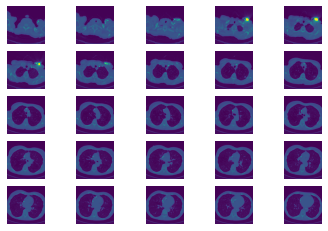

In [8]:
### WRITE CODE IN HERE. You can have up to 4 cells for this question, but only one is required #######
fig,ax = plt.subplots(5,5)
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(volCT[:,:,(5*i+j)*5])
        ax[i,j].axis('off')
plt.rcParams['figure.figsize']=(60,36)
######################################################################################################

# Step 3 (5 points)

If you dont already know about numerical types, take a look [here](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html) and/or [here](https://www.tutorialspoint.com/numpy/numpy_data_types.htm).

### Deliverable: 

What is the default numerical type used to store raw image data in DICOM files? Answer in the cell below.

In the coding cell below that one, convert all the pixels in your volume to a float32 type number between 0.0 and 1.0; output the min, max, and dtype (datatype) of the pixels in your volume before and after you convert.

**Answer:** **int16**, but in the volume which is a 3D array, it's float64

In [9]:
### WRITE CODE IN HERE. You can have up to 2 cells for this question, but only one is required #######

def reportMinMaxDtype(array):
    print('min is: ', np.min(array))
    print('max is: ', np.max(array))
    print('dtype is: ',array.dtype)

def normalize(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

In [10]:
volCT_converted = normalize(volCT).astype('float32')
print('before converting: ')
reportMinMaxDtype(volCT)
print('after converting: ')
reportMinMaxDtype(volCT_converted)
######################################################################################################

before converting: 
min is:  0.0
max is:  4095.0
dtype is:  float64
after converting: 
min is:  0.0
max is:  1.0
dtype is:  float32


# Step 4 (10 points)

Now that we have our 3D matrix of lung CT data, we can try to segment out our lung. We know from lecture that the pixel values of CT scans are given in Hounsfield units, where lower Hounsfield units correspond to low density materials (like air) that are not highly attenuative for X-rays and higher Hounsfield units correspond to highly attenuative materials, like bone.

<img src = "figures/histWithThresh.png"> 

That red line separating the two groups of pixels is the [Otsu's threshold](https://en.wikipedia.org/wiki/Otsu%27s_method). We can find a nice separating value of our two modes with [this Otsu’s method](http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html).

### Deliverable:

A histogram of the Hounsfield units from a typical CT scan will be significantly bimodal! Why?

**Answer:** The peak in the lower values denotes air and water, which is typical, and the peak in the higher values is thick tissue and bones, which is also typical.

Next, find the Otsu's threshold in your volume of pixels and plot the histogram of of your pixels with this line like the example figure. You will find these links ([1](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html), [2](https://matplotlib.org/1.2.1/examples/pylab_examples/histogram_demo.html), and [3](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.axvline.html)) useful if you have not done this before.

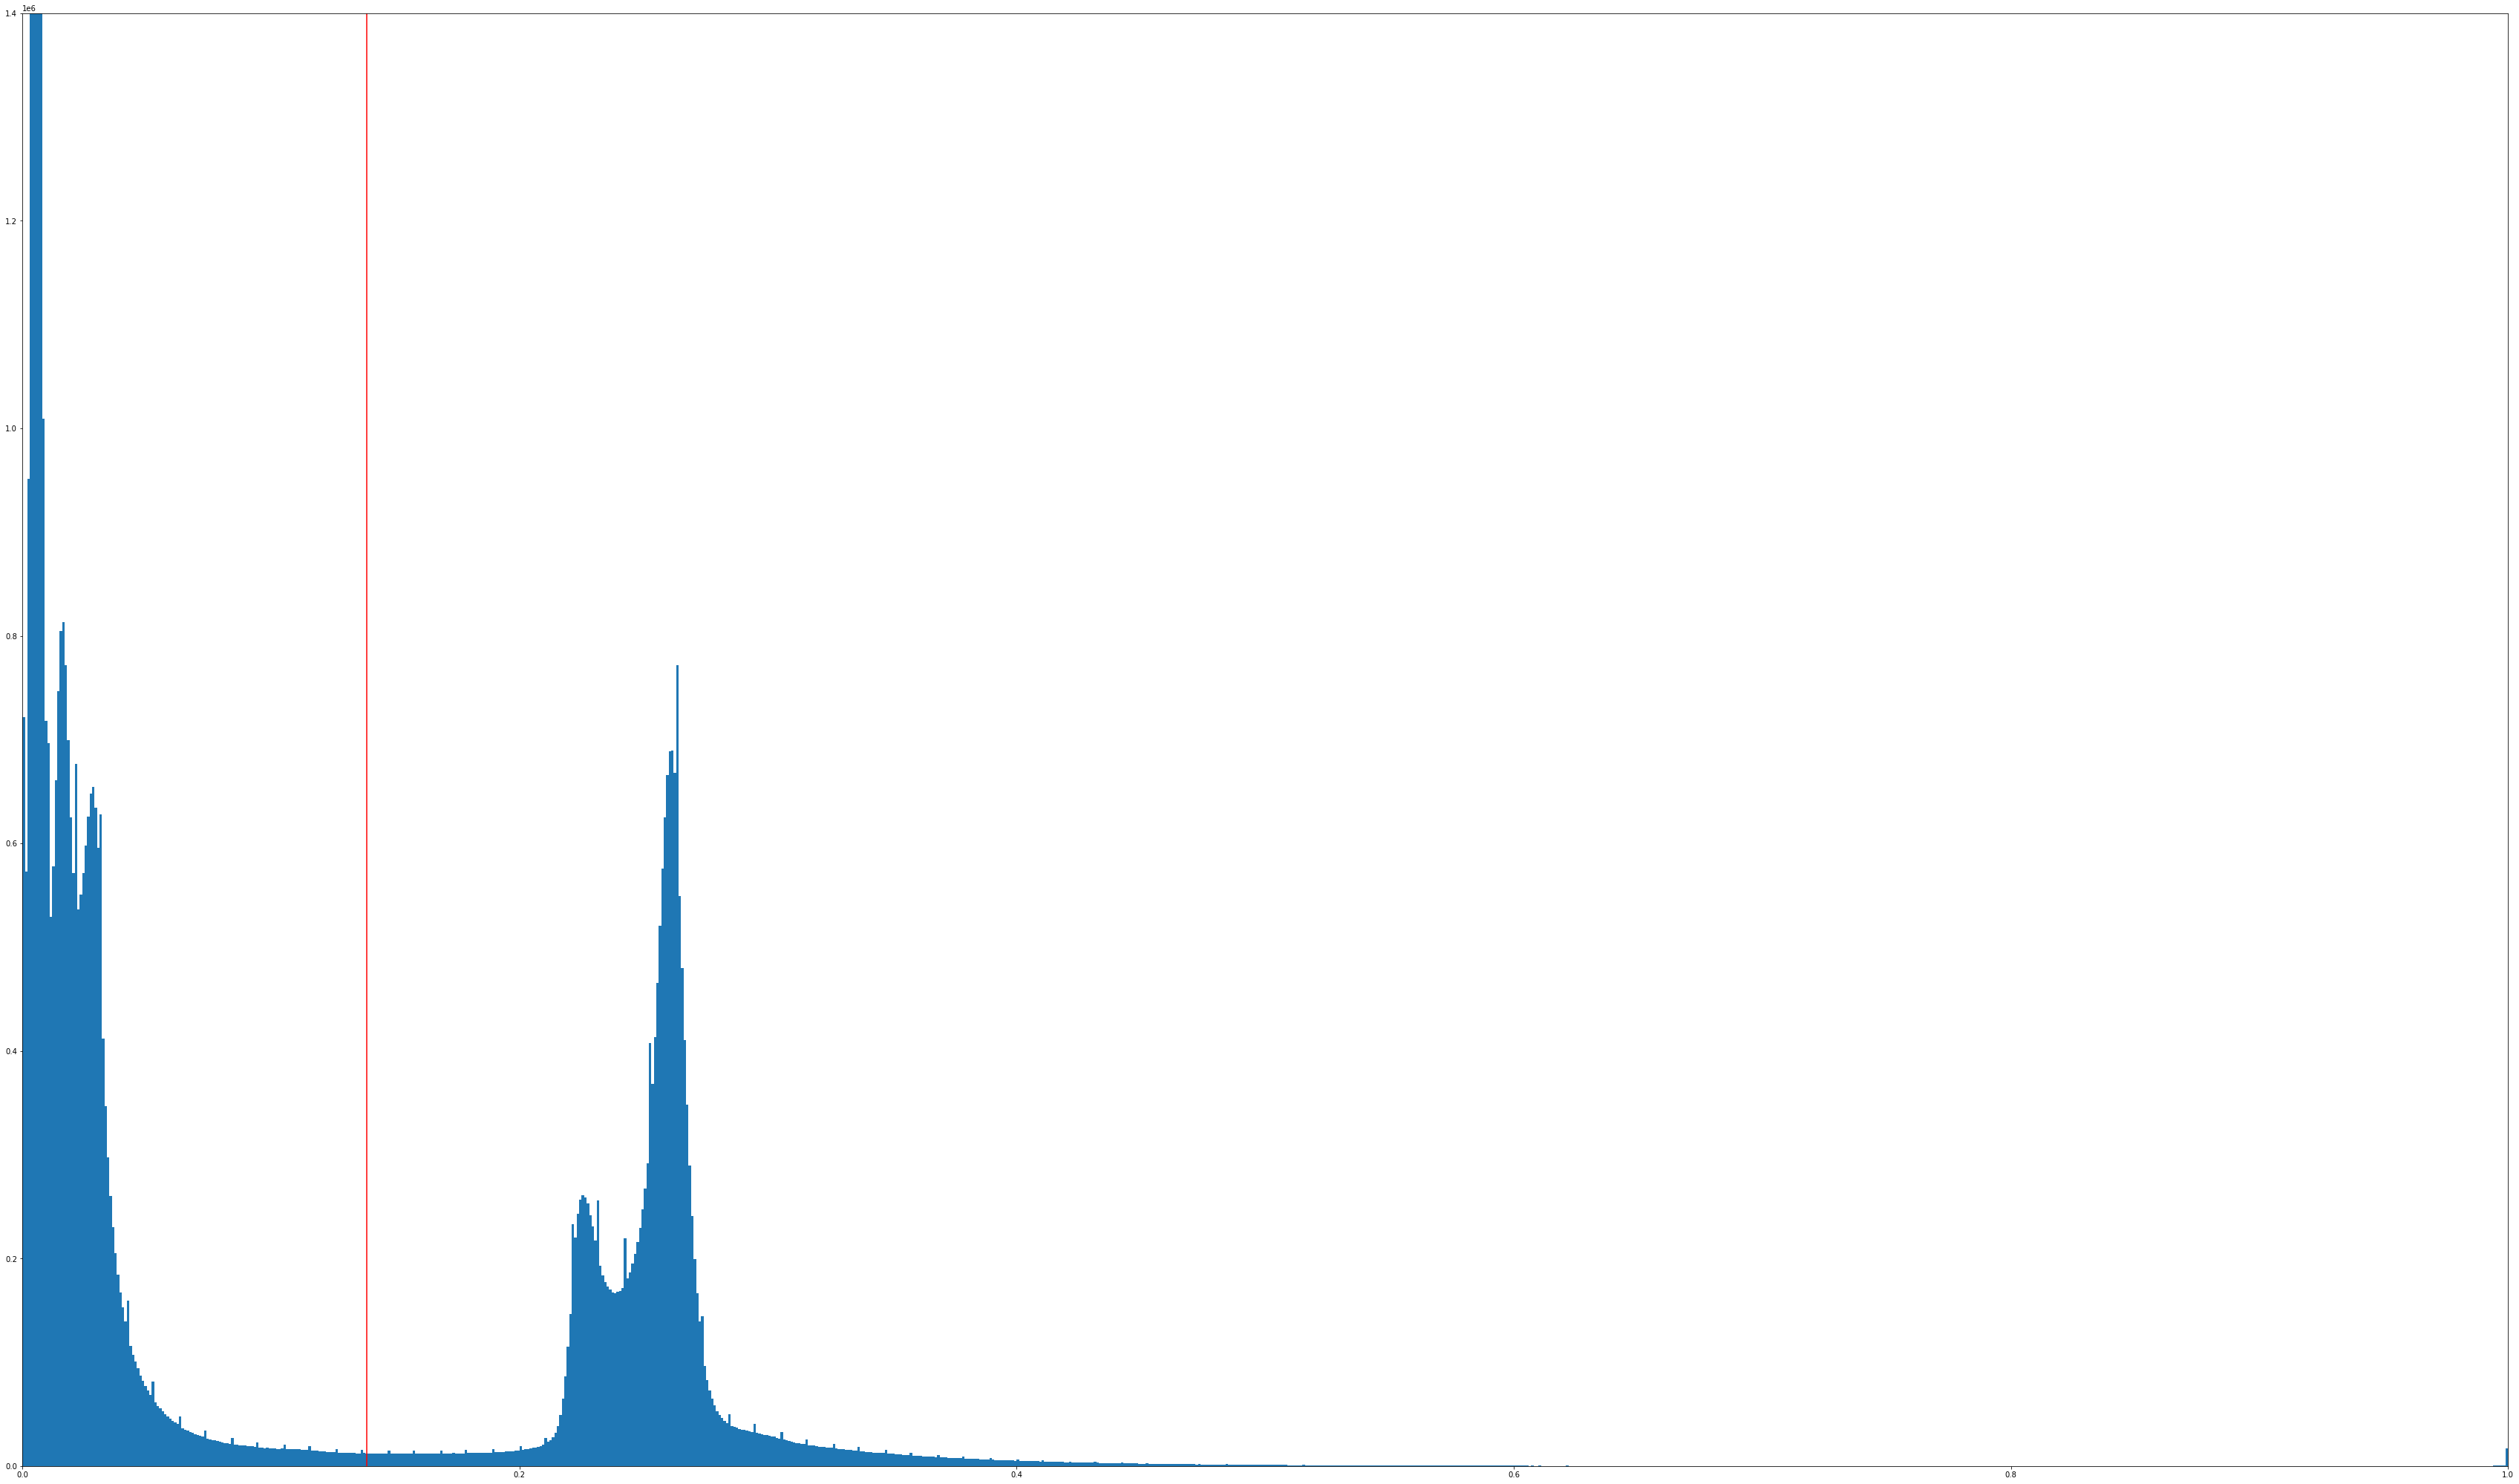

In [11]:
### WRITE CODE IN HERE. You can have up to 2 cells for this question, but only one is required #######
otsu_threshold = threshold_otsu(volCT_converted)
plt.hist(np.ravel(volCT_converted),1000)
plt.ylim([0,1400000])
plt.xlim([0,1])
_=plt.plot([otsu_threshold,otsu_threshold],[0,1400000],'r')
######################################################################################################

# Step 5 (10 points)

We can now take a look at the performance of Otsu’s threshold. We want all the pixels less than Otsu’s threshold since the lung is in the darker (low Hounsfield units) part of the image.

<img src="figures/otsu.png">

Despite the crude binary cutoff, we can see that this is really close to what we want for a final result, albeit a little noise.

### Deliverable:

Display for us one slice of the CT scan showing a binary image after applying thresholding using Otsu's method.

In [12]:
### WRITE CODE IN HERE. You can have up to 2 cells for this question, but only one is required #######
def displayOne(slice):
    plt.imshow(slice)
    plt.rcParams['figure.figsize'] = [15,9]

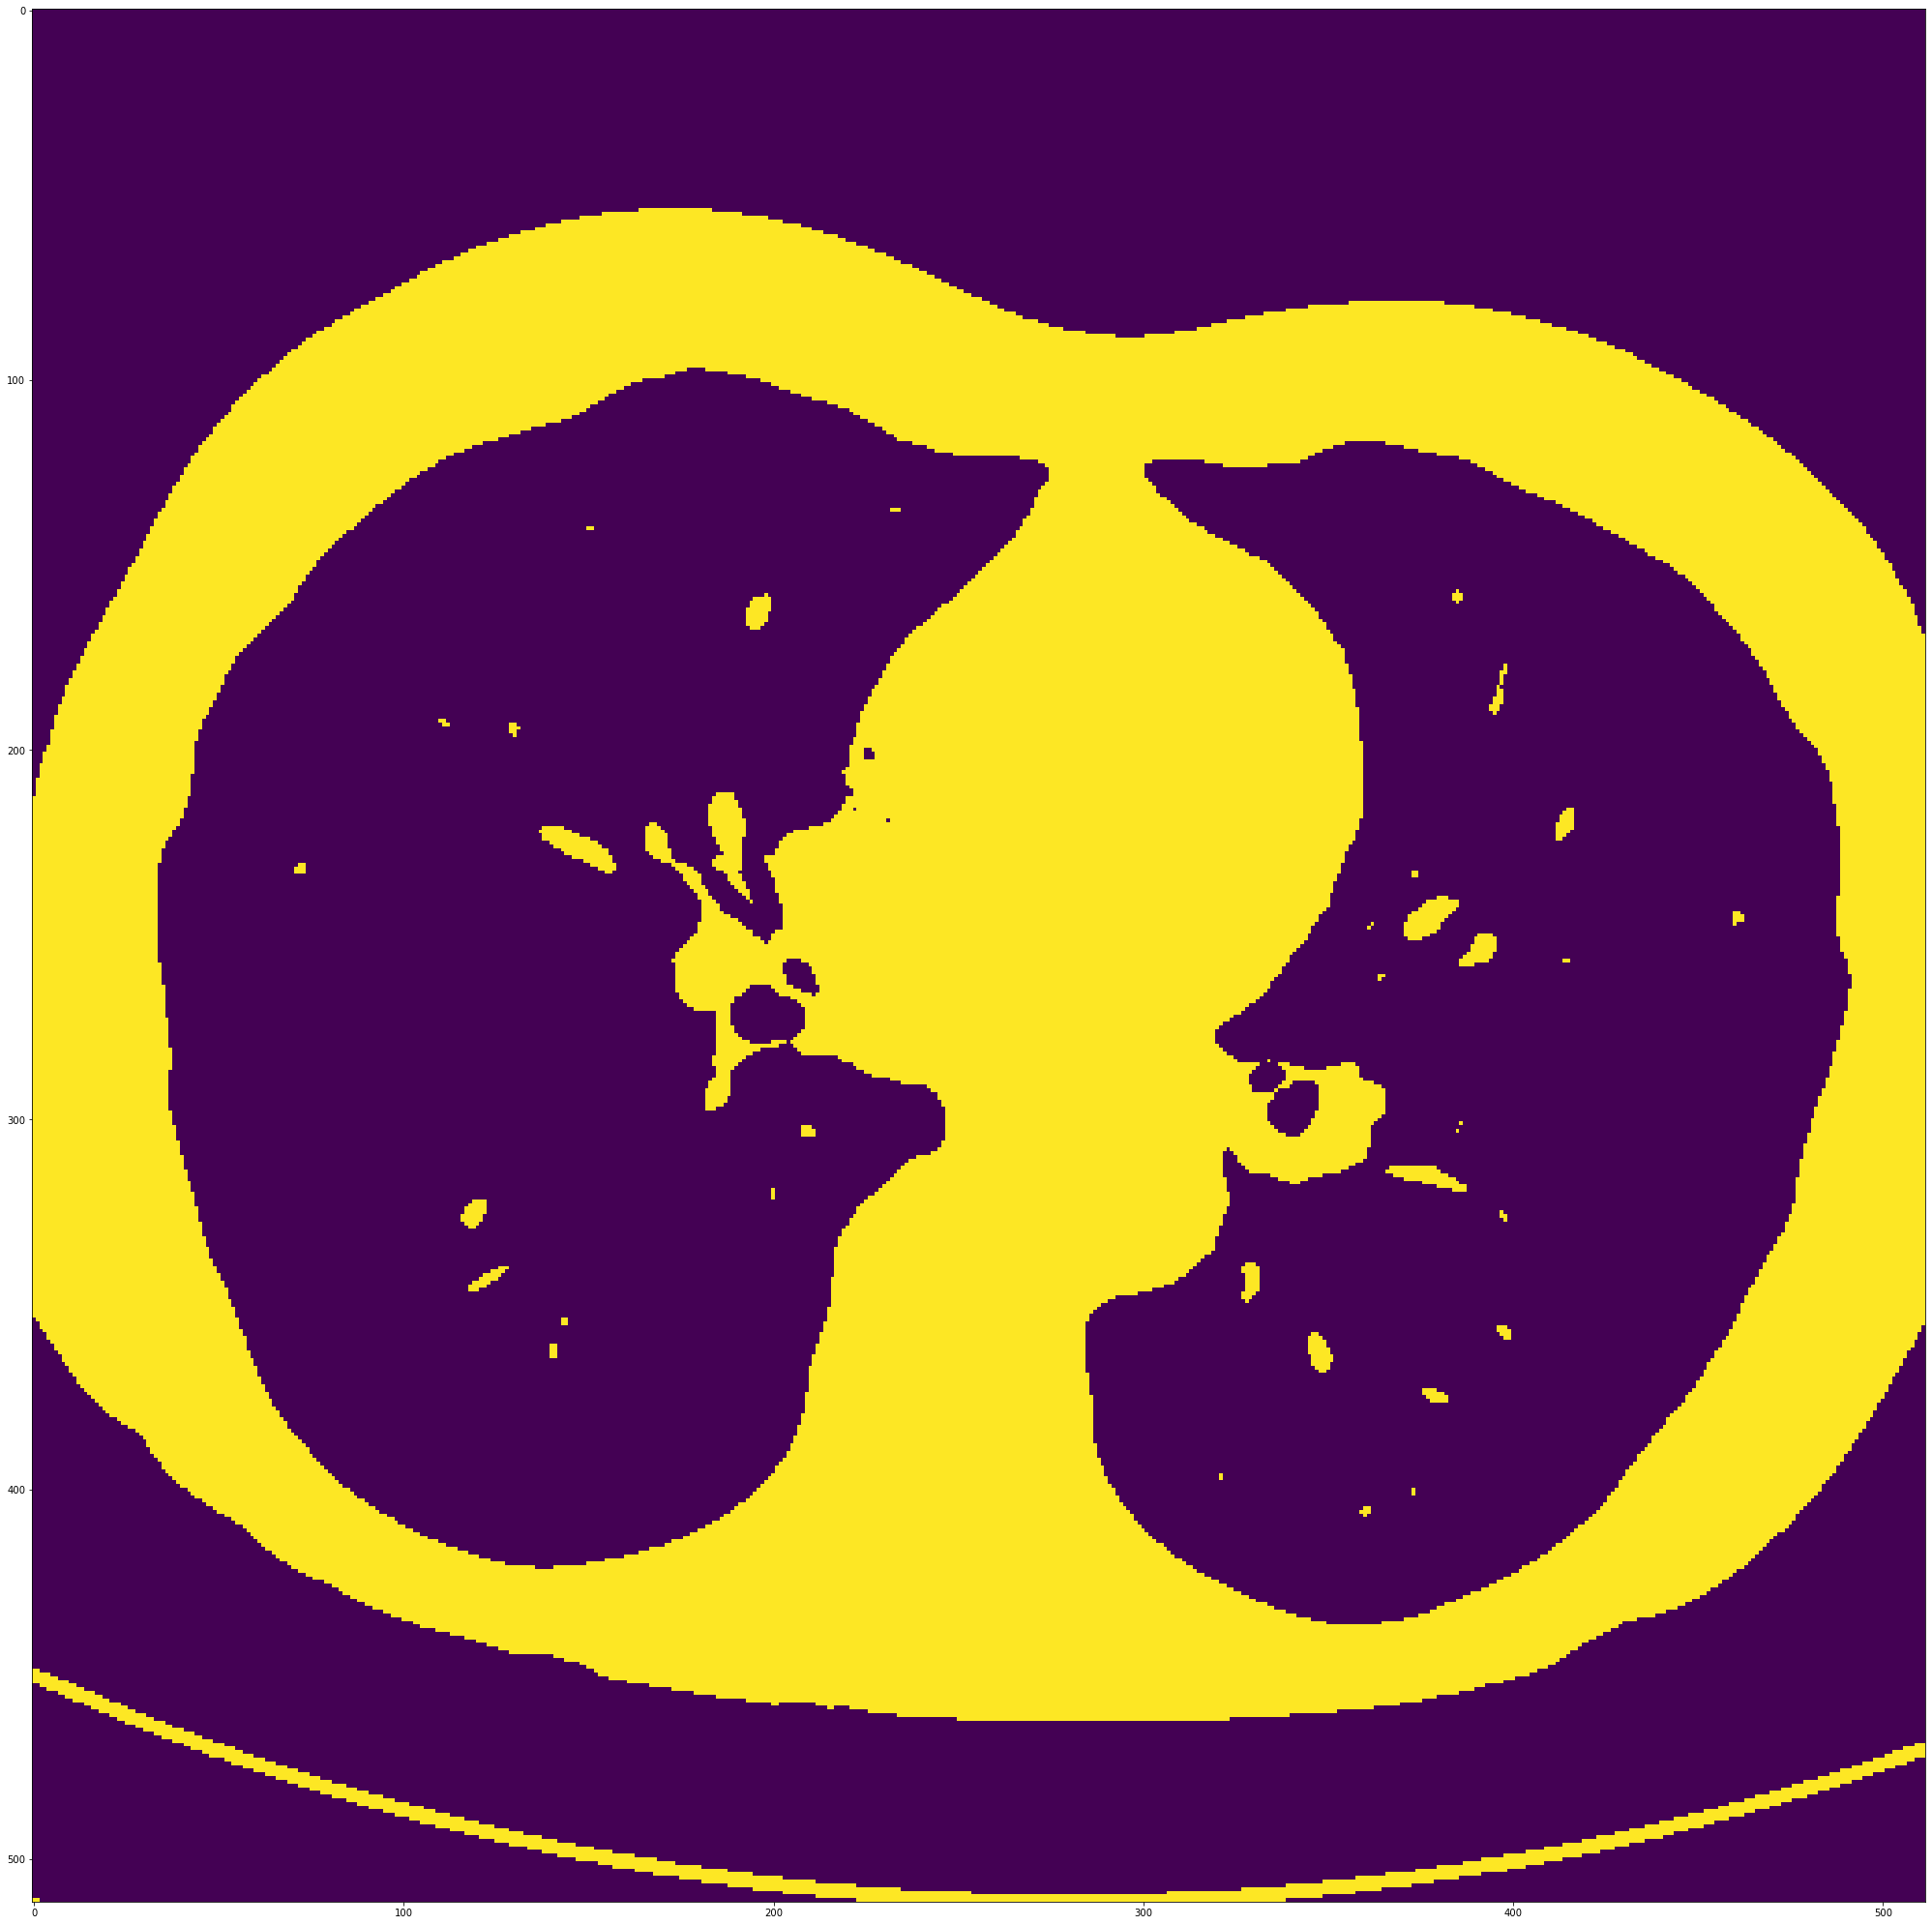

In [13]:
displayOne(volCT_converted[:,:,100] > otsu_threshold)
######################################################################################################

# Step 6 (30 points)

Our dark lungs are surrounded by lighter-colored tissue, which is then again surrounded by darkness. Our lung segmentation is thus, interestingly, completely separated from the segmentation of the outside air. These two sets of binary connected components are completely unconnected. Can you think of a simple way of differentiating between the lungs and the air outside the body?

Here's one way to do it - we assume that the outside air will always be touching the edge of the image and the lungs will not:

<img src="figures/pseudocode2.png">

However the segmentation is still rough around the edges. There are a few pixels of noise around the main lung (components that weren’t touching the edges, but still aren’t part of the lung). Luckily for us, these bits are quite small in size. We can therefore quickly filter them out based on their volume. We want to choose connected components that have a volume greater than some threshold $V$. You can choose $V$ arbitrarily (most noise will have pixel counts in the double digits or maybe low hundreds), as long as the lung volume should have a pixel count several orders of magnitude higher.

Here would be a possible pseudo-algorithm for this task:

<img src="figures/pseudocode3.png">

After this, we just want to smooth out the edges. The segmentation of our lung looks very ragged because it wasn’t able to pick out the lighter colored blood vessels in the lung. We can do this smoothing with a binary closing algorithm, provided by the `scikit-image` package (`skimage.morphology.binary_closing`). It works for both 2-dimensional and 3-dimensional binary matrices.

### Deliverable:

Implement the steps described here and display for us an ordered sample of the cuts from your boolean CT scan volume that has been smoothed, with only the pixels of the lung and trachea as 1/true, and everything else as 0/False,  like this:

<img src="figures/final.png">

In [14]:
### WRITE CODE IN HERE. You can have up to 5 cells for this question, but only one is required #######
# Return the edge pixels' group of a image
def edge(two_d_array):
    s = two_d_array.shape
    left_top = np.append(two_d_array[0,:],two_d_array[:,0])
    botton_right = np.append(two_d_array[s[0]-1,:],two_d_array[:,s[1]-1])
    return set(np.append(left_top,botton_right))

######################################################################################################

In [15]:
### WRITE CODE IN HERE. You can have up to 5 cells for this question, but only one is required #######
otsu_threshold = threshold_otsu(volCT_converted)
volBW = volCT_converted < otsu_threshold

# mask the components that touches the edge
for slice in range(volBW.shape[2]):
    slice_label, n_features = label(volBW[:,:,slice])
    edge_pixels = edge(slice_label)
    for i in range(1,n_features+1):
        if i in edge_pixels:
            mask = (slice_label != i)
            volBW[:,:,slice] = (mask * volBW[:,:,slice]).astype('bool')
            
V = 1000
threeDComp, n_comp = label(volBW)

In [16]:
for i in range(n_comp):
    if np.sum(threeDComp==i) < V:
        mask = (threeDComp != i)
        volBW = (mask * volBW).astype('bool')

In [17]:
### WRITE CODE IN HERE. You can have up to 5 cells for this question, but only one is required #######
smoothed_volBW = binary_closing(volBW)
#################################################

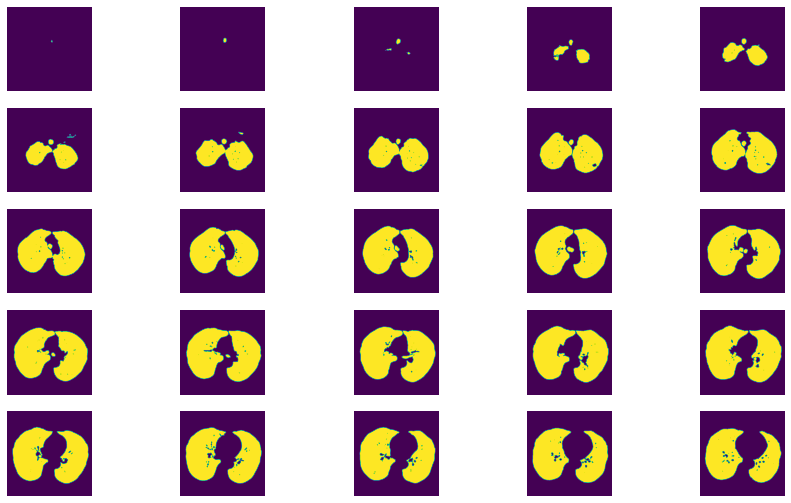

In [18]:
### WRITE CODE IN HERE. You can have up to 5 cells for this question, but only one is required #######
fig,ax = plt.subplots(5,5)
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(smoothed_volBW[:,:,(5*i+j)*5])
        ax[i,j].axis('off')
plt.rcParams['figure.figsize']=(60,36)
######################################################################################################

# Step 7 (5 points each, 15 points total)

Show that the segmentation works on 3 more scans.

## Deliverable:

Same as Step 6, but with different scans.

In [19]:
# Get the 3D volume
def get_volume(scan_path, list_of_slices, slice_shape):
    n_slices = len(os.listdir(scan_path))
    volCT = np.zeros(slice_shape + [n_slices])
    series_number = []
    for slice in range(n_slices):
        slice_path = os.path.join(scan_path,list_of_slices[slice])
        ds = dicom.read_file(slice_path)
        volCT[:,:,ds.InstanceNumber-1] = ds.pixel_array
        series_number += [ds.InstanceNumber]
    return volCT,[ds.RescaleSlope, ds.RescaleIntercept], series_number

# Mask components that touches the edge
def maskEdge(volBW):
    for sl in range(volBW.shape[2]):
        slice_label, n_features  = label(volBW[:,:,sl])
        edge_pixels = edge(slice_label)
        for i in range(1,n_features+1):
            if i in edge_pixels:
                mask = (slice_label != i)
                volBW[:,:,sl] = (mask * volBW[:,:,sl]).astype('bool')
    return volBW

# Volume Filter
def volumeFilter(volBW, V):
    threeDComp, n_comp = label(volBW)
    for i in range(n_comp):
        if np.sum(threeDComp==i) < V:
            mask = (threeDComp != i)
            volBW = (mask * volBW).astype('bool')
    return volBW

# Display 25 figures
def display25(smoothed_volBW):
    fig,ax = plt.subplots(5,5)
    for i in range(5):
        for j in range(5):
            ax[i,j].imshow(smoothed_volBW[:,:,(5*i+j)*5])
            ax[i,j].axis('off')
    plt.rcParams['figure.figsize']=(60,36)
    
# Read path, load file, read image, convert image
# Get a scan number and returns converted CT volumn
# If normalize=False, the Hounsfield Units are calculated
def preprocessing(scan_number, nor=True):
    # file path
    scans_path = "/Users/terryli/Codes/BIOMEDIN260/CT_chest_scans"
    list_of_scans = os.listdir(scans_path)
    scan_path = os.path.join(scans_path, list_of_scans[scan_number])
    list_of_slices = os.listdir(scan_path)
    # get size
    sample_slice = dicom.read_file(os.path.join(scan_path,list_of_slices[0]))
    sample_slice_shape = list(sample_slice.pixel_array.shape)
    # Set volume
    volCT,theta, _ = get_volume(scan_path, list_of_slices, sample_slice_shape)
    if nor:
        volCT_converted = normalize(volCT).astype('float32')
    else:
        volCT_converted = volCT * theta[0] + theta[1]
    return volCT_converted

# Detect the circle background
def detectCircle(CTVol):
    # If there is a region of certain area that are zeros
    zero_area = np.mean(CTVol==0)
    return zero_area - (1 - np.pi/4) < 0.1

# process the circle area by assigning all the zeros to be the secondly smallest value
def processCircle(CTVol):
    if detectCircle(CTVol):
        secondMin = np.min(CTVol + (CTVol==0).astype('int'))
        CTVol[CTVol==0] = secondMin
    return CTVol
    
# Do segmentation
def segmentation(scan_number, display=True):
    # get converted CT volumn
    volCT_converted = preprocessing(scan_number)
    if detectCircle(volCT_converted):
        volCT_converted = processCircle(volCT_converted)
    # Compute threshold
    otsu = threshold_otsu(volCT_converted)
    # Segment
    volBW = volCT_converted < otsu
    volBW = maskEdge(volBW)
    volBW = volumeFilter(volBW,1000)
    # Smoothing
    smoothed_volBW = binary_closing(volBW)
    # Display
    if display:
        display25(smoothed_volBW)
    return smoothed_volBW

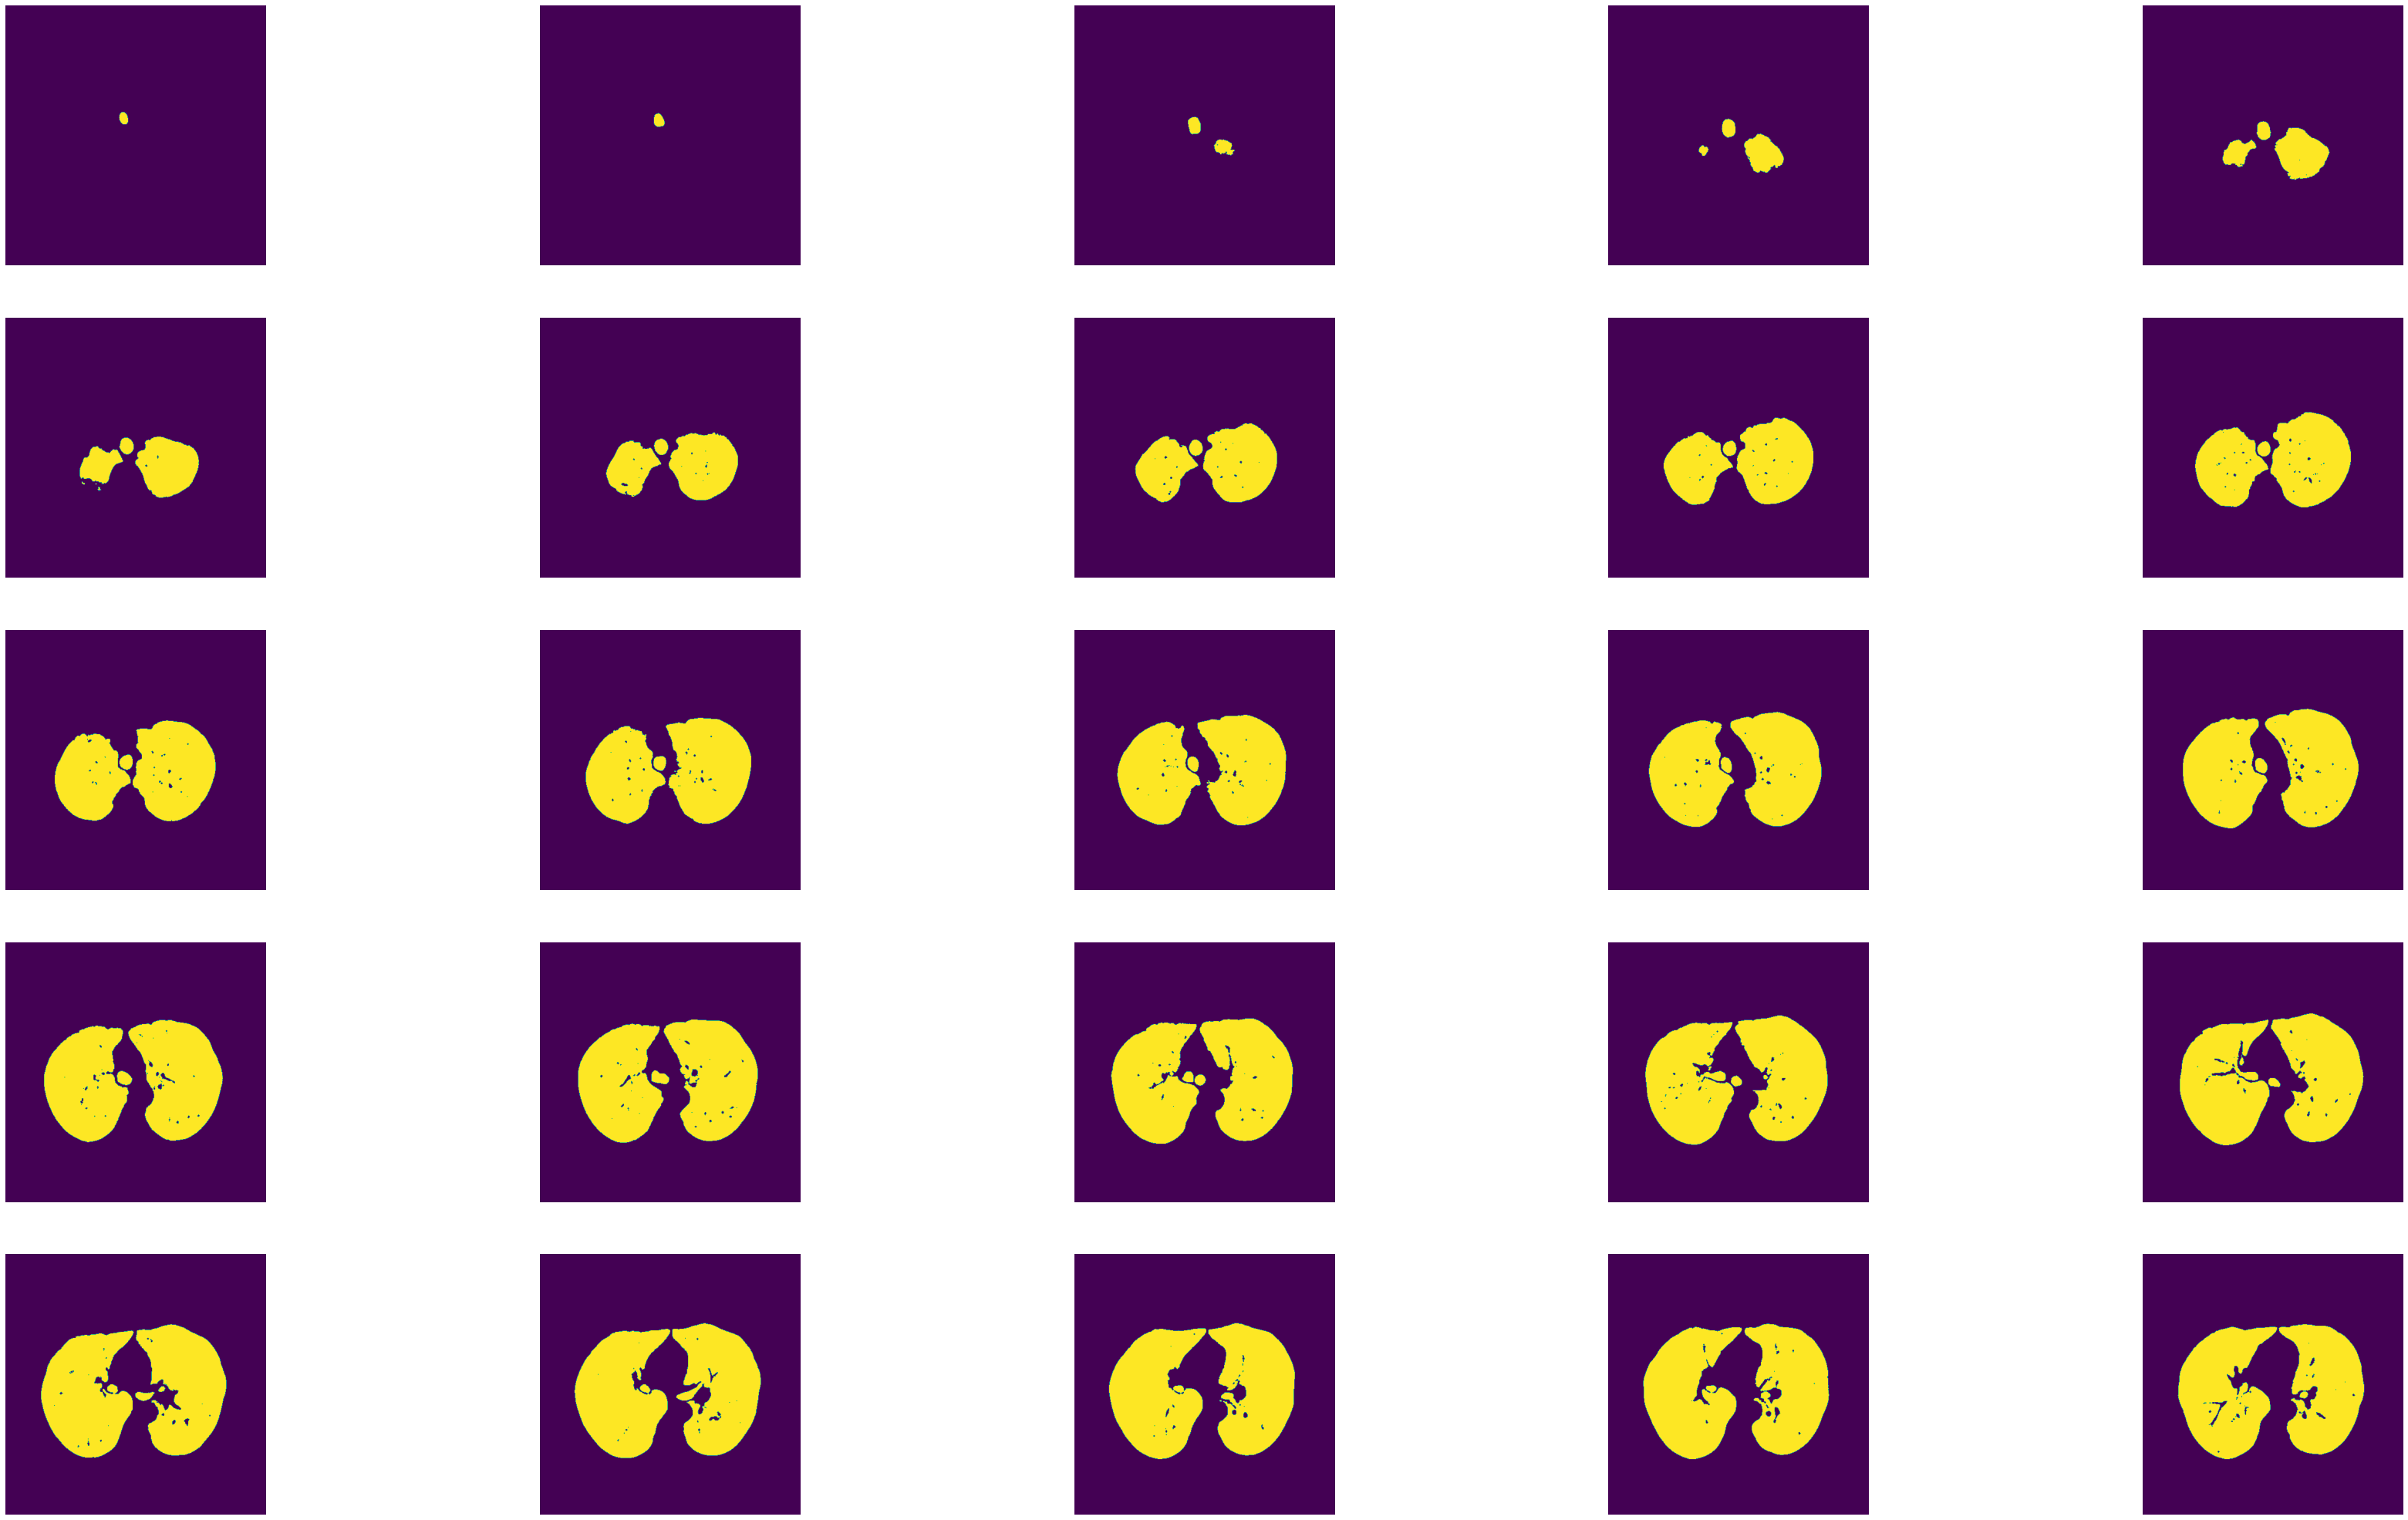

In [20]:
# First scan_num = 8
segmented = segmentation(8)

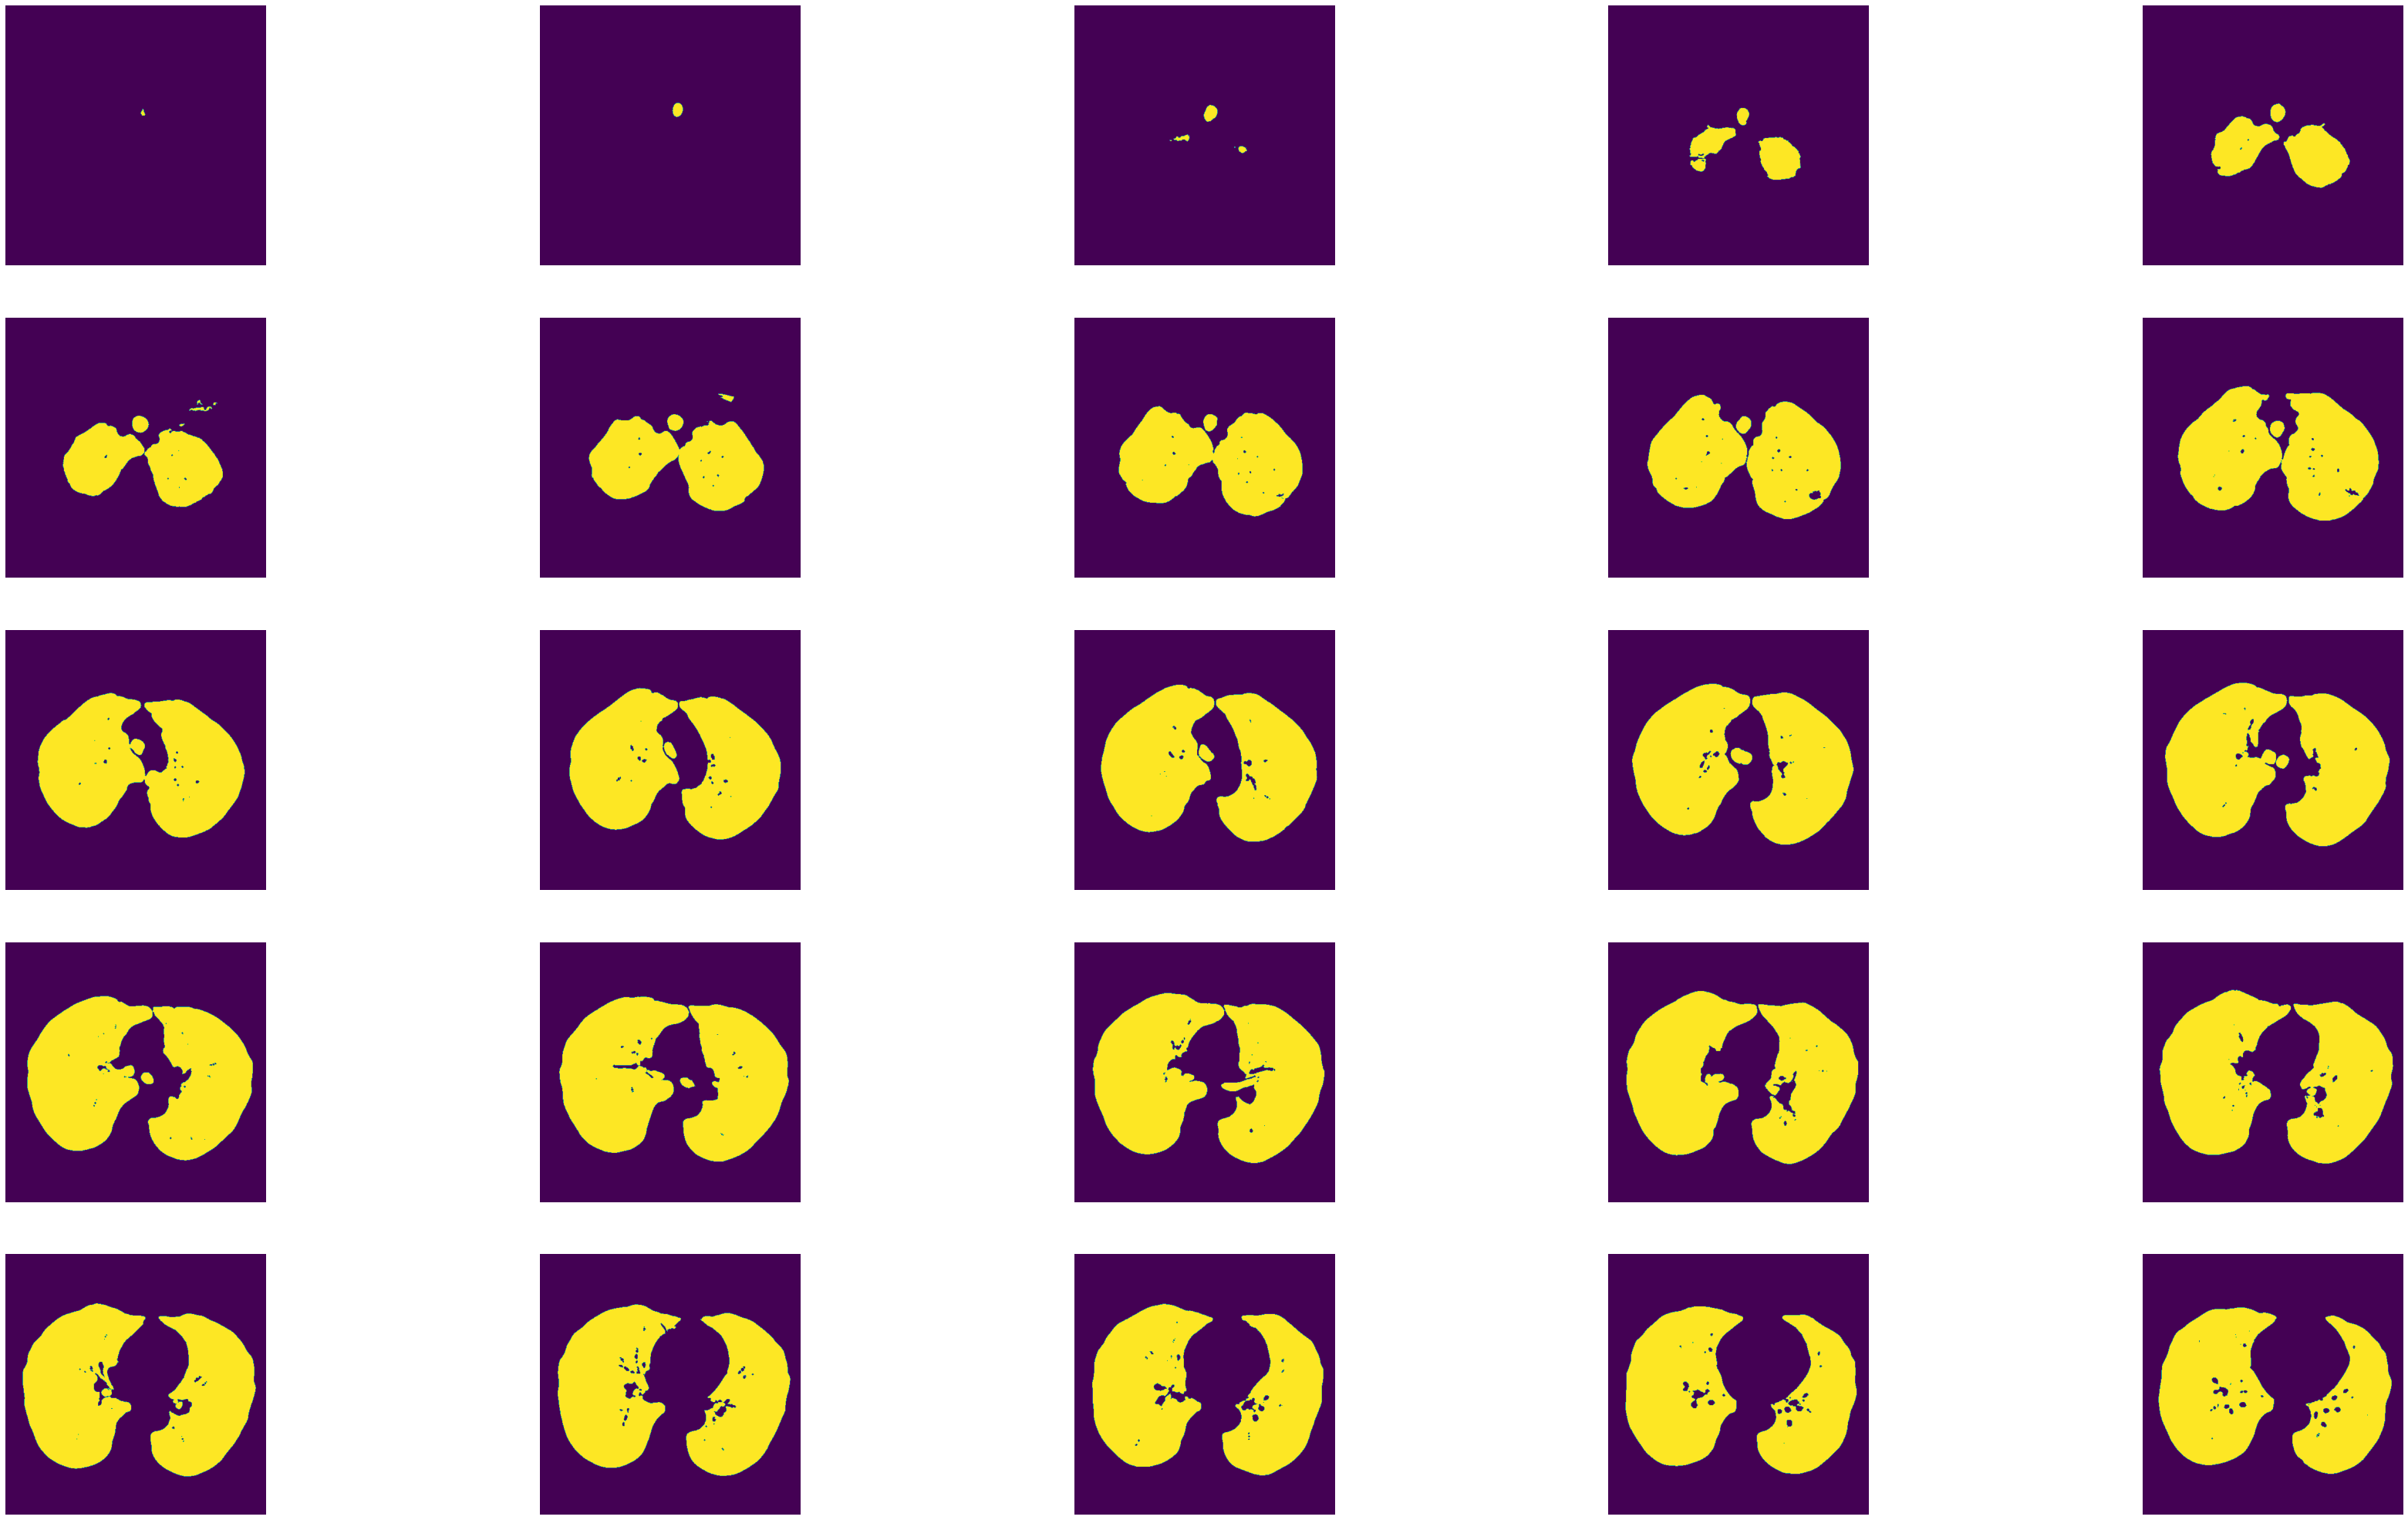

In [21]:
# Second scan_num = 5
segmented = segmentation(5)

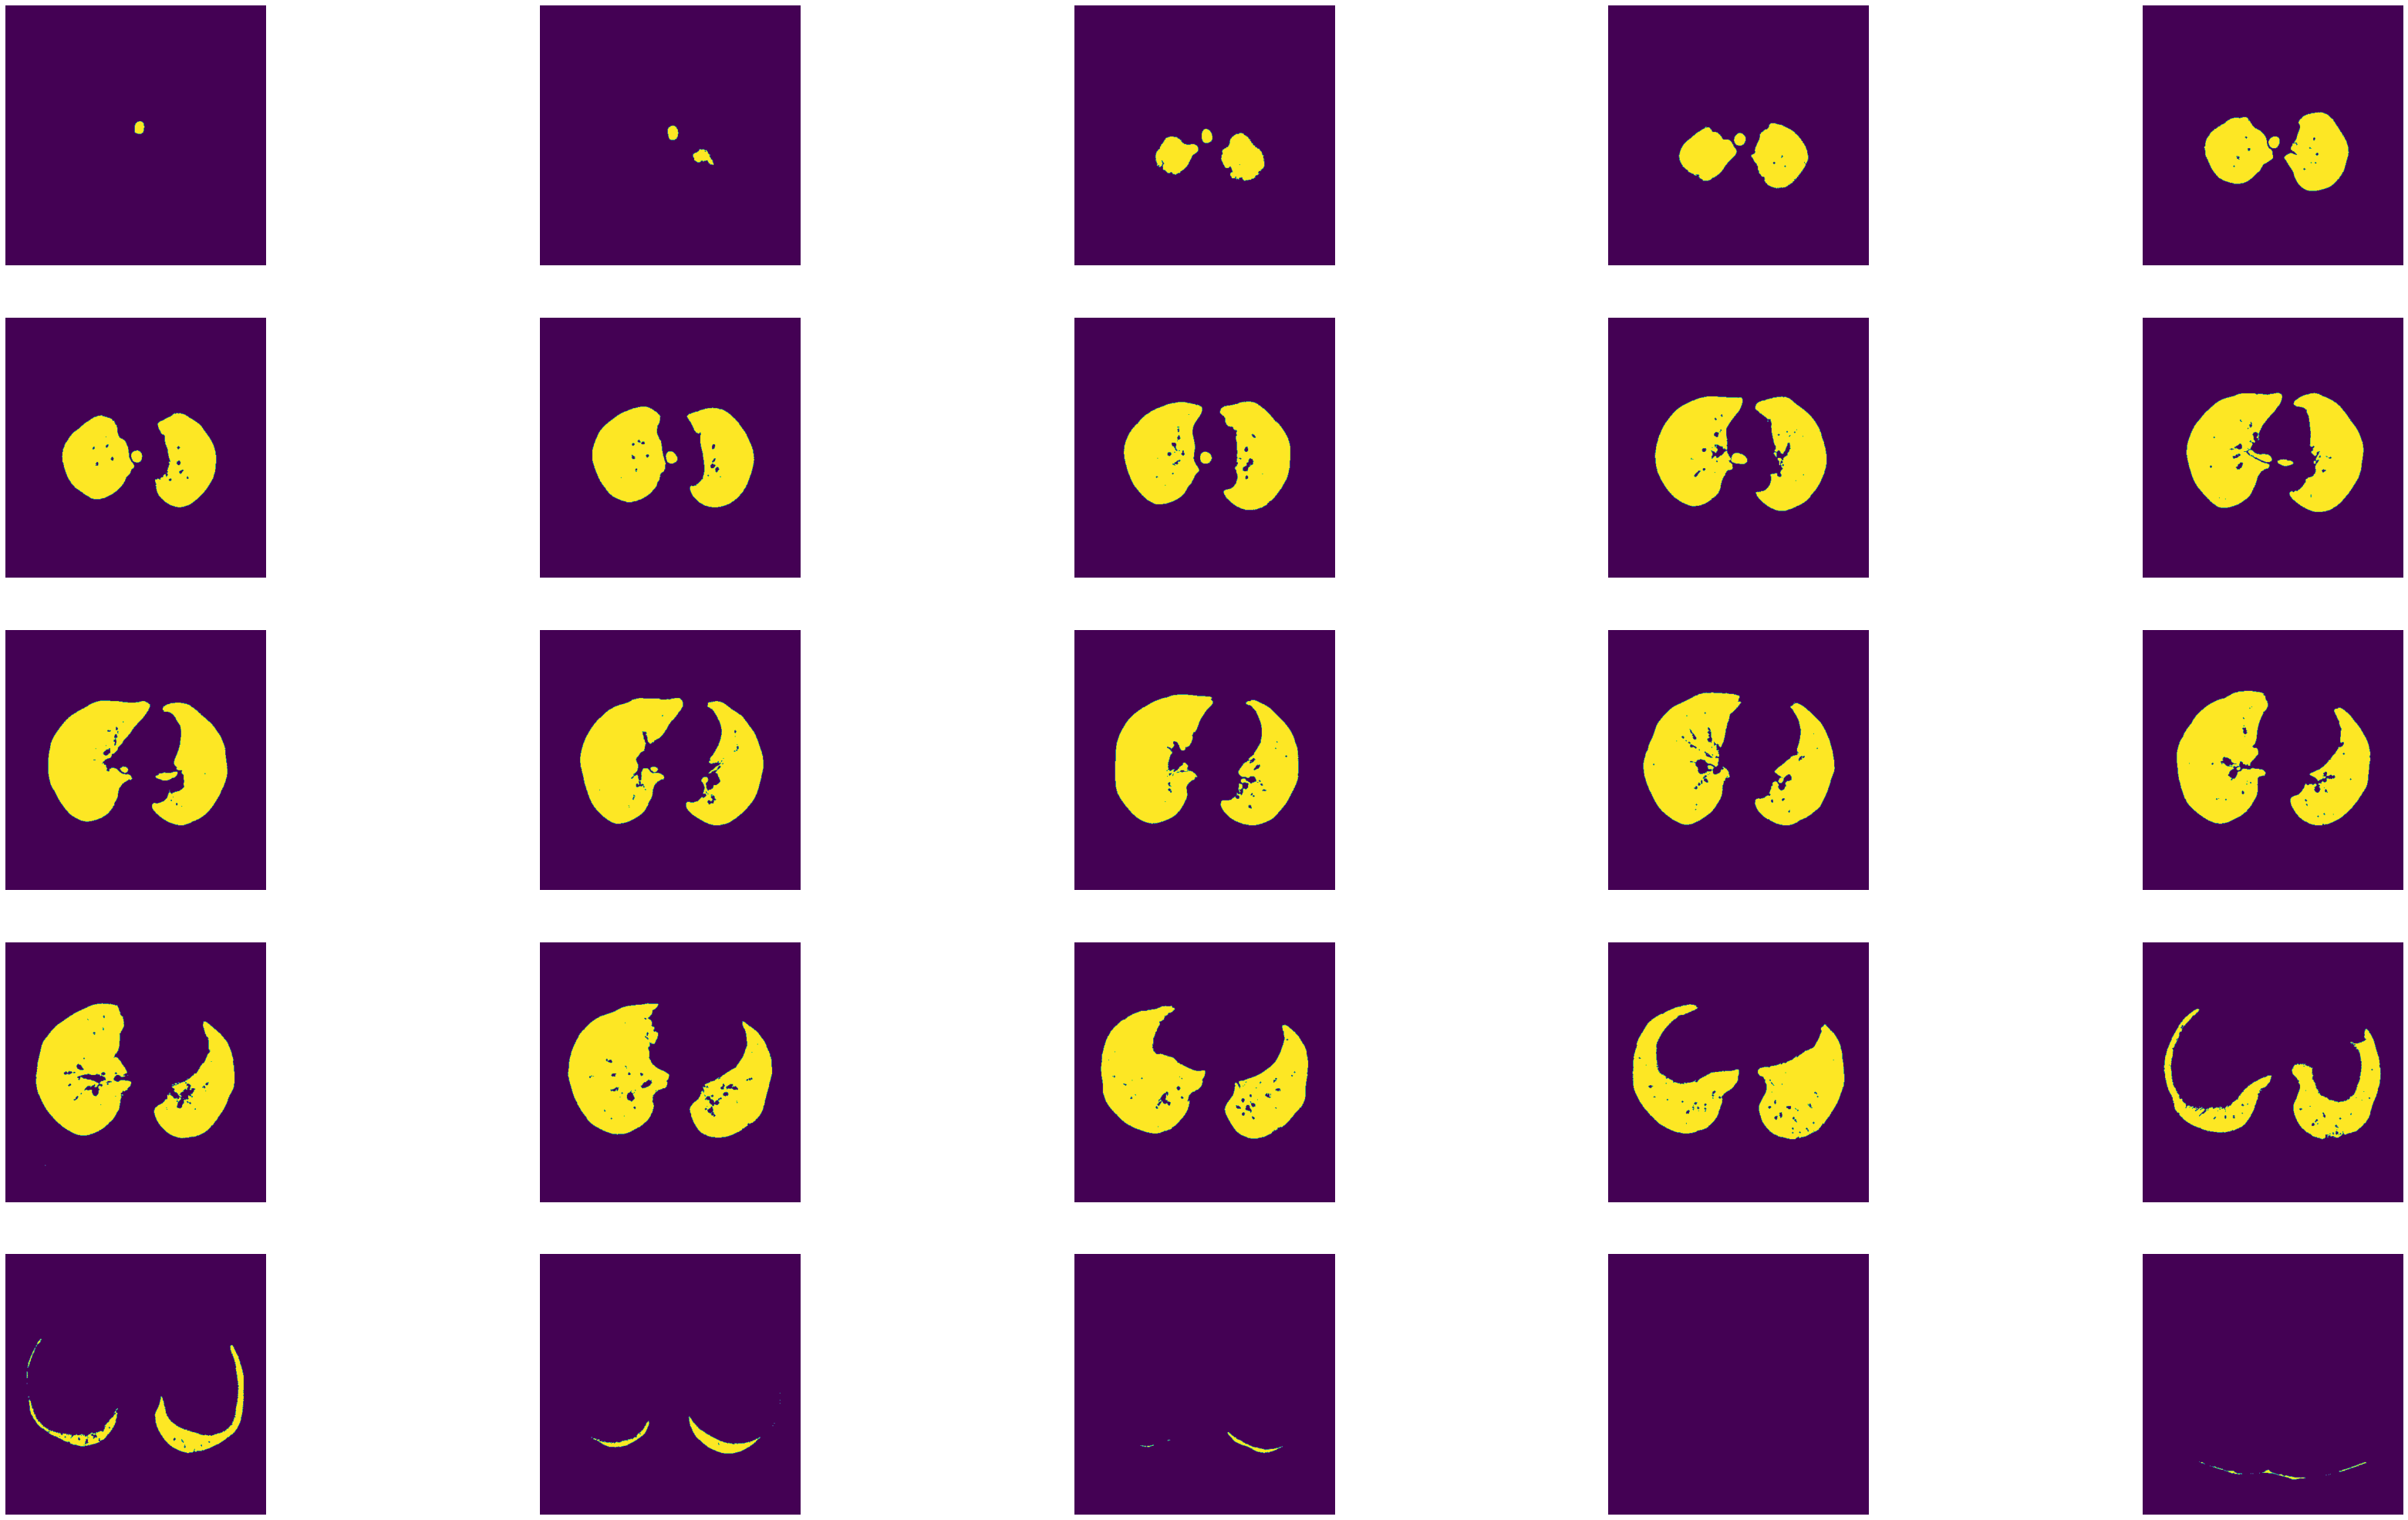

In [22]:
# Third scan_num = 6
segmented = segmentation(6)

# Step 8 (Bonus 15 points, 5 points each)

If you’ve finished everything above, you’ve already done a full fledged segmentation. However, for an extra challenge, you can try your hand at:

1. Removing just the trachea so that your segmentation is just on the left and right lung without any of the trachea or bronchi. 

2. Separating out the two halves of the lung into left/right lungs.

3. There are a ton of python packages that help you visualize the lung as a whole, but it might be a difficult to grasp. We highly recommend looking up some marching cube algorithms, but the easier way to go would probably use something like Fiji. Simply [download Fiji](https://imagej.net/Fiji/Downloads) (available for Windows, Mac, and Linux). You can save all your 3D segmentation as binary image slices. Then, using Fiji, simply read in your image sequence (be sure to name your images some numeric count or something so that Fiji knows what order to read the images in). Then, go to `Plugins -> 3D Viewer`. This should give you a figure like what you see below:

<img src="figures/fiji.png">

Show us that this works on at least two scans.

In [23]:
### WRITE CODE IN HERE. You can have up to 5 cells for this question, but only one is required #######

# Task 1: REMOVE TRACHEA
# Iteratively using region grow to construct trachea area
def iterativeRegionGrow(CTVol_hu, initial_seed, verbose=False):
    # parameters
    n_slices = CTVol_hu.shape[2]
    # inital values
    regionVol = np.zeros(CTVol_hu.shape)
    prev_area = 10000
    tol = 10
    prev_tol = 0
    step = 8
    
    # Max iteration number: 500
    for i in range(500):
        # Get segmented region
        regionVol = skimage.morphology.flood(CTVol_hu, seed_point=initial_seed, tolerance=tol, connectivity=2)
        # new_seed = getSeed(regionVol)
        area = np.sum(regionVol)
        # print (for debug)
        if verbose:
            print('iteration: ' ,i)
            print('step:', step)
            print('tol ', tol)
            print('area: ', area)
            print('area ratio: ', area/prev_area)
            print('\n')
        # If the area is more than twice as large as previous iteration
        if area > 2 * prev_area and prev_area != 1:
            # And step <= 1, terminate loop
            if step <= 1:
                break
            # Let step to be half
            else:
                step = 0.5 * step
                tol = prev_tol + step
        else:
            prev_tol = tol
            tol = tol + step
            if area > prev_area:
                prev_area = area
    if verbose:
        print('tol ', prev_tol)
        print('prev area', prev_area)
        print(initial_seed)
        print('seed value', CTVol_hu[initial_seed])
    regionVol = skimage.morphology.flood(CTVol_hu, seed_point=initial_seed, tolerance=prev_tol, connectivity=2)
    return regionVol


def getSeed(CTVol):
    return tuple(np.array(center_of_mass(CTVol)).astype('int'))

def thikenTrachea(trachea_thin):
    trachea = np.zeros(trachea_thin.shape)
    for num in range(trachea_thin.shape[2]):
        trachea[:,:,num] = skimage.morphology.dilation(trachea_thin[:,:,num], selem=skimage.morphology.disk(3))
    return trachea

def removeTrachea(CTVol_hu, segmented):
    # Select initial seed from the most top slices
    initial_seed = getSeed(segmented[:,:,0:5])
    # Do region growing
    trachea_thin = iterativeRegionGrow(CTVol_hu, initial_seed, verbose=False)
    trachea = thikenTrachea(trachea_thin)
    # Segment trachea
    trachea_smoothed = skimage.morphology.binary_closing(trachea)
    segmented_wo_trachea = segmented * (trachea_smoothed==False)
    return segmented_wo_trachea


# Task 2: SEPERATE LEFT AND RIGHT LUNG
# Get the upper region centroid (60 pixels wide) of a 
# anchor(tuple of len 2) in an 2D image
def getUpperRegionMask(image_shape, anchor):
    mask = np.zeros(image_shape)
    mask[0:anchor[0],anchor[1]-30:anchor[1]+30]=1
    return mask

def getLowerRegionMask(image_shape, anchor):
    mask = np.zeros(image_shape)
    mask[anchor[0]:,anchor[1]-30:anchor[1]+30]=1
    return mask

def getAdjacentMask(image_shape, anchor, length=50):
    mask = np.zeros(image_shape)
    mask[anchor[0]-length:anchor[0]+length,anchor[1]-length:anchor[1]+length]=1
    return mask

def getMiddlePointsOfNBlackRows(aoi, centroid, length, n=3):
    n_black_point = 3 + aoi.shape[0] - 2 * length
    col_list = np.arange(centroid[1]-length,centroid[1]+length)
    mid_points = []
    # For all rows
    for row in range(aoi.shape[1]):
        # Find the rows
        if np.sum(aoi[row,:]==0) == n_black_point:
            # Find the pixels
            pixel_cols = (aoi[row,centroid[1]-50:centroid[1]+50]==0) * col_list
            # Find mid column
            mid_col = int(np.sum(pixel_cols)/3)
            mid_points += [[row, mid_col]]
    return mid_points

def getLineMask(image_shape, points):
    mask = np.zeros(image_shape)
    for i in range(len(points)):
        if i == 0:
            pointA = points[i]
        else:
            pointB = pointA
            pointA = points[i]
            rols, cols = skimage.draw.line(pointA[0], pointA[1], pointB[0], pointB[1])
            mask[rols, cols]=1
    mask_thick = skimage.morphology.dilation(mask, selem=skimage.morphology.disk(2))
    return mask_thick

# Detect if a slice has two seperated lung parts by
# judging whether area(largest component) > 9 * area(second largest component) (that is not seperated) 
# or just one or zero component detected
def detectSeperated(CT_slice):
    img_labeled, n = label(CT_slice)
    if n <= 1:
        return False
    else:
        sizes = np.bincount(img_labeled.ravel())
        size_sorted = np.copy(sizes)
        size_sorted[::-1].sort()
        area_largest = size_sorted[1]
        area_second = size_sorted[2]
        return (not area_largest > 9 * area_second)

def seperateSlice(CT_slice, region_kw='upper'):
    # Step two: Get intested area around centroid of connected region
    anchor = getSeed(CT_slice)
    if region_kw=='upper' or region_kw=='Upper':
        mask = getUpperRegionMask(CT_slice.shape, anchor)
    elif region_kw=='lower' or region_kw=='Lower':
        mask = getLowerRegionMask(CT_slice.shape, anchor)
        
    centroid = getSeed(CT_slice * mask)
    # Get interested area
    length = 50
    adjacentMask = getAdjacentMask(CT_slice.shape, centroid, length=length)
    aoi = CT_slice * adjacentMask


    # Step three:
    # Detect the rows in aoi where there are 3 black points (except for other area)
    # and get middle point of those rows as a list
    mid_points = getMiddlePointsOfNBlackRows(aoi, centroid, length)


    # Step Four: create a 'line' mask by connecting the mid points and 
    # thiken the line to mask the image
    lineMask = getLineMask(CT_slice.shape, mid_points)
    slice_seperated = (lineMask==0) * CT_slice
    
    return slice_seperated

def seperateLung(CTVol_segmented):
    CTVol_seperated = np.zeros(CTVol_segmented.shape)
    for num_section in range(CTVol_segmented.shape[2]):
        sliced = CTVol_segmented[:,:,num_section]
        # Step one: Judge whether the slice has connected left and right lung
        # If the largest component is 9 times larger than the second
        if not detectSeperated(sliced):
            
            slice_seperated = seperateSlice(sliced)
            
            # Check whether this slice is seperated or not
            # If not, and area of this region is larger than 150,000, seperate Lower region
            if not detectSeperated(slice_seperated) and np.sum(sliced) > 15000:
                slice_seperated = seperateSlice(slice_seperated, region_kw='lower')
            CTVol_seperated[:,:,num_section] = slice_seperated
        else:
            CTVol_seperated[:,:,num_section] = sliced
    return CTVol_seperated

# Display comparison of two fig
def displayCompare(CT_original, CT_after, s=50, title_original='original', title_after='after'):
    CT_slice_original = CT_original[:,:,s]
    if len(CT_after.shape) == 2:
        CT_slice_after = CT_after
    else:
        CT_slice_after = CT_after[:,:,s]
    fig,ax = plt.subplots(1,2)
    ax[0].set_title(title_original, fontsize=100)
    ax[0].imshow(CT_slice_original)
    ax[1].set_title(title_after, fontsize=100)
    ax[1].imshow(CT_slice_after)
    plt.rcParams['figure.figsize']=(60,30)
    plt.show()
######################################################################################################

NOTE: ONLY **ONE CELL** IS USED FOR CODING, LATER CELLS ARE FOR RESULT DISPLAY

In [24]:
# Results for scan_num = 5
CTVol_hu = preprocessing(5, nor=False)
segmented = segmentation(5, display=False)
segmented_wo_trachea = removeTrachea(CTVol_hu, segmented)
CTVol_seperated = seperateLung(segmented_wo_trachea)

/Users/terryli/opt/miniconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:1359: RuntimeWarning: invalid value encountered in double_scalars
  for dir in range(input.ndim)]
/Users/terryli/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in long_scalars
/Users/terryli/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: overflow encountered in long_scalars
/Users/terryli/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: overflow encountered in long_scalars


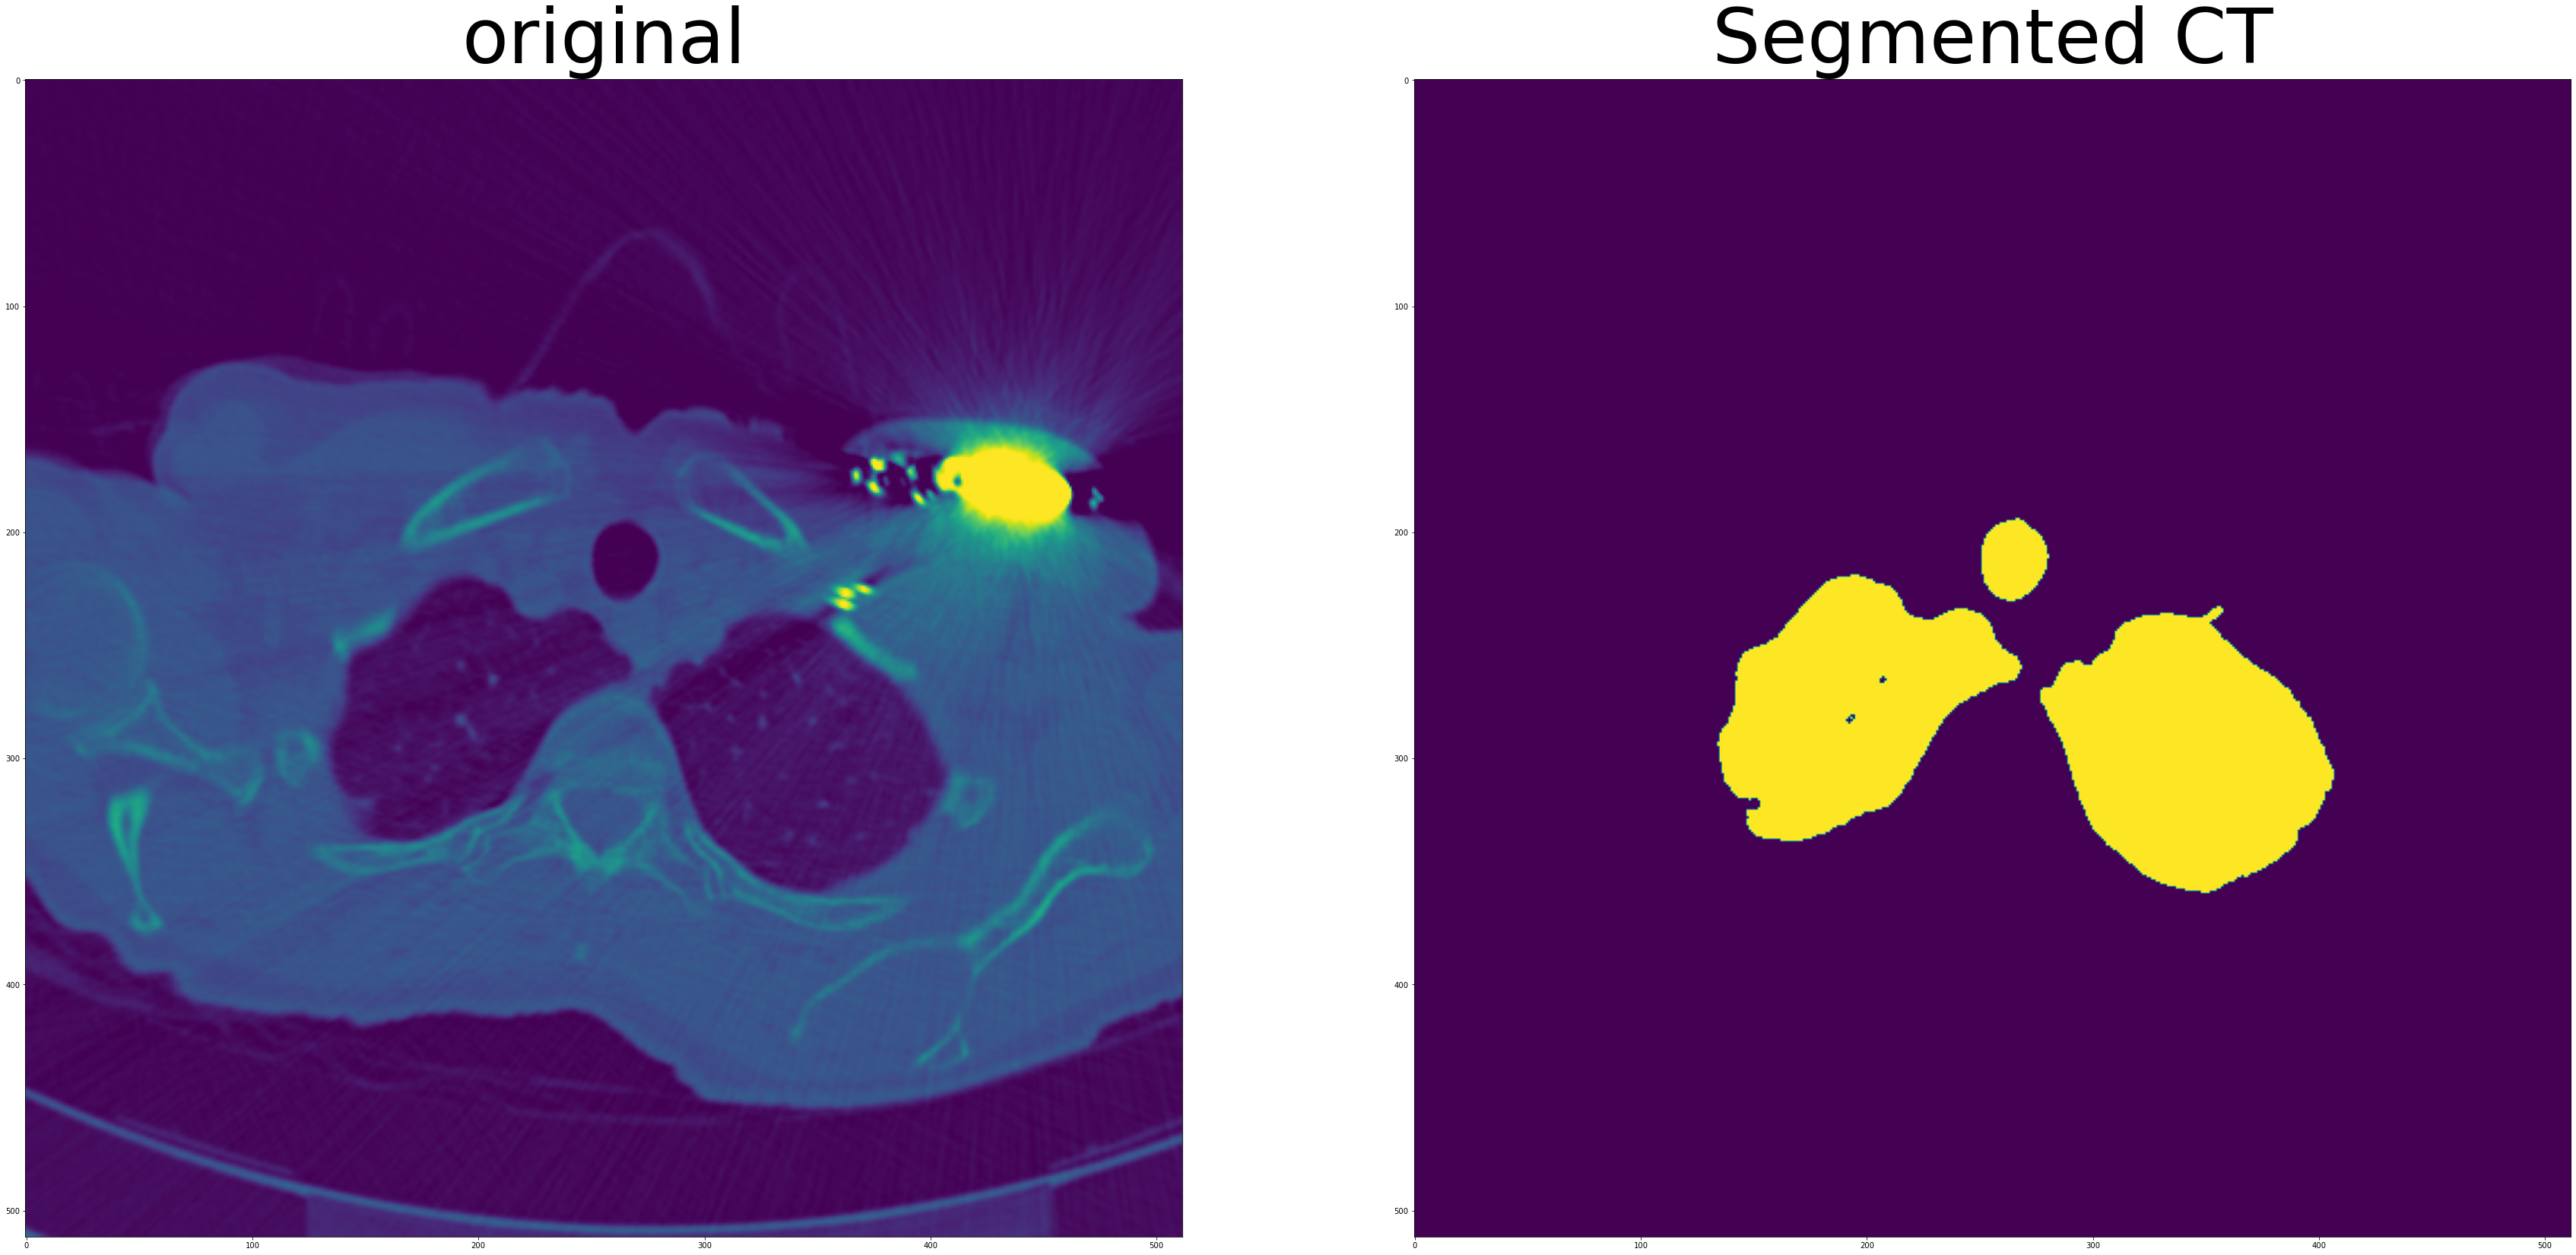

In [25]:
# Result 0: Lung segmentation
displayCompare(CTVol_hu, segmented, s=20, title_after='Segmented CT')

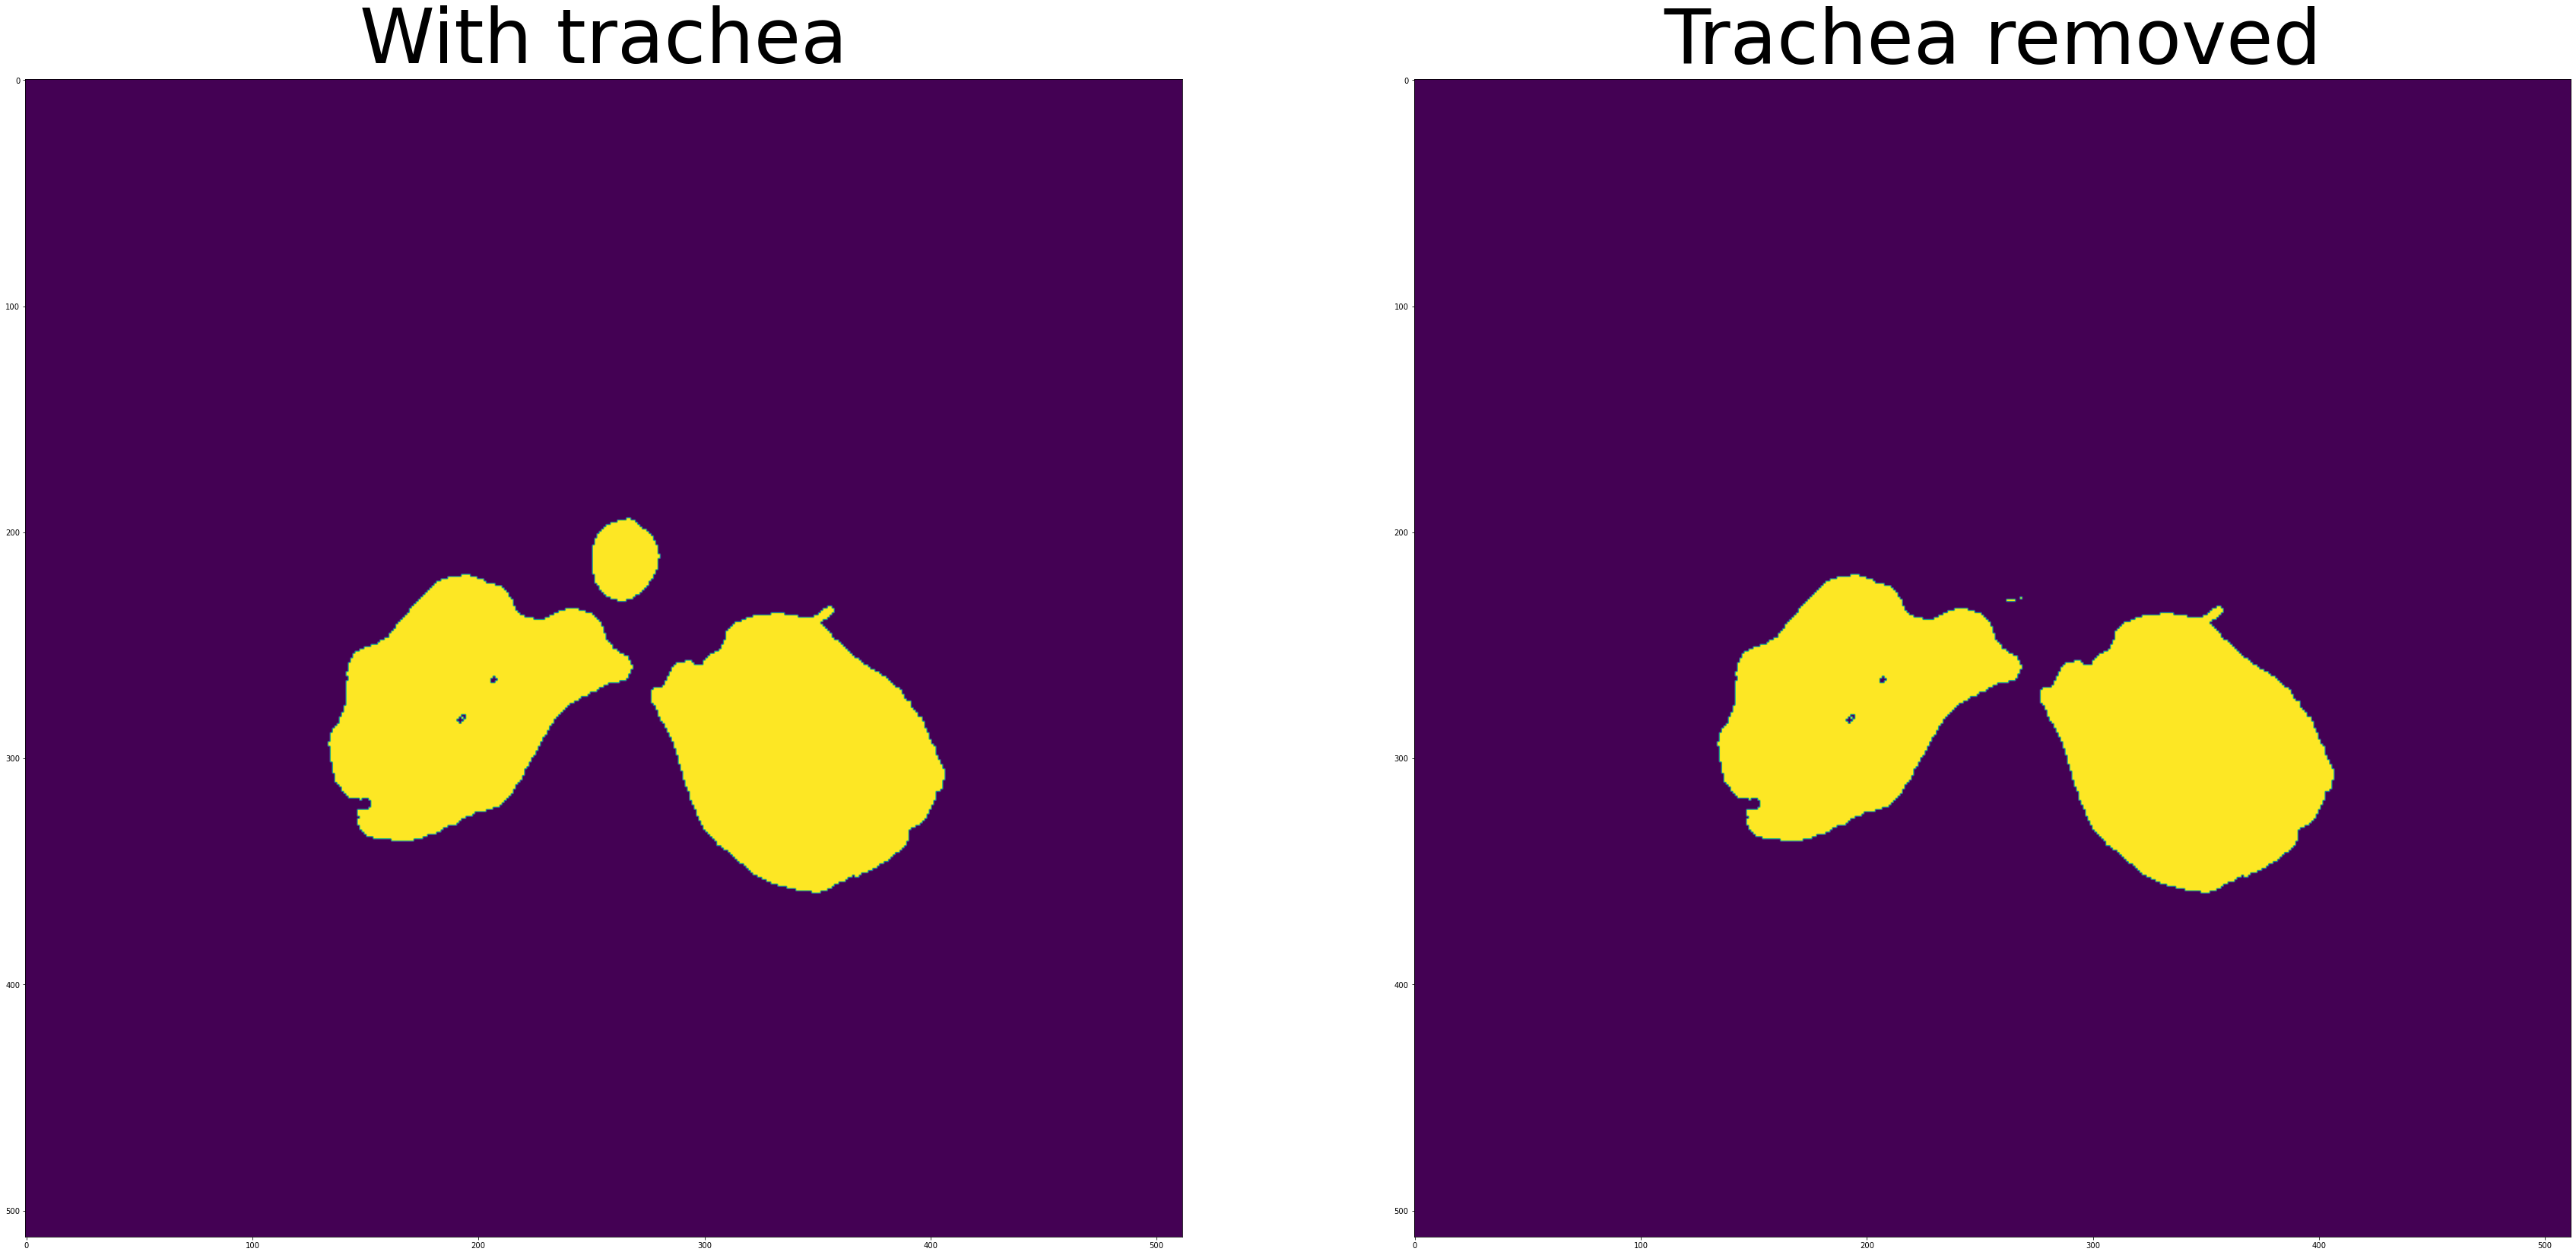

In [26]:
# Result 1: Trachea removed compared to segmented lung
displayCompare(segmented, segmented_wo_trachea, s=20, title_original='With trachea', title_after='Trachea removed')

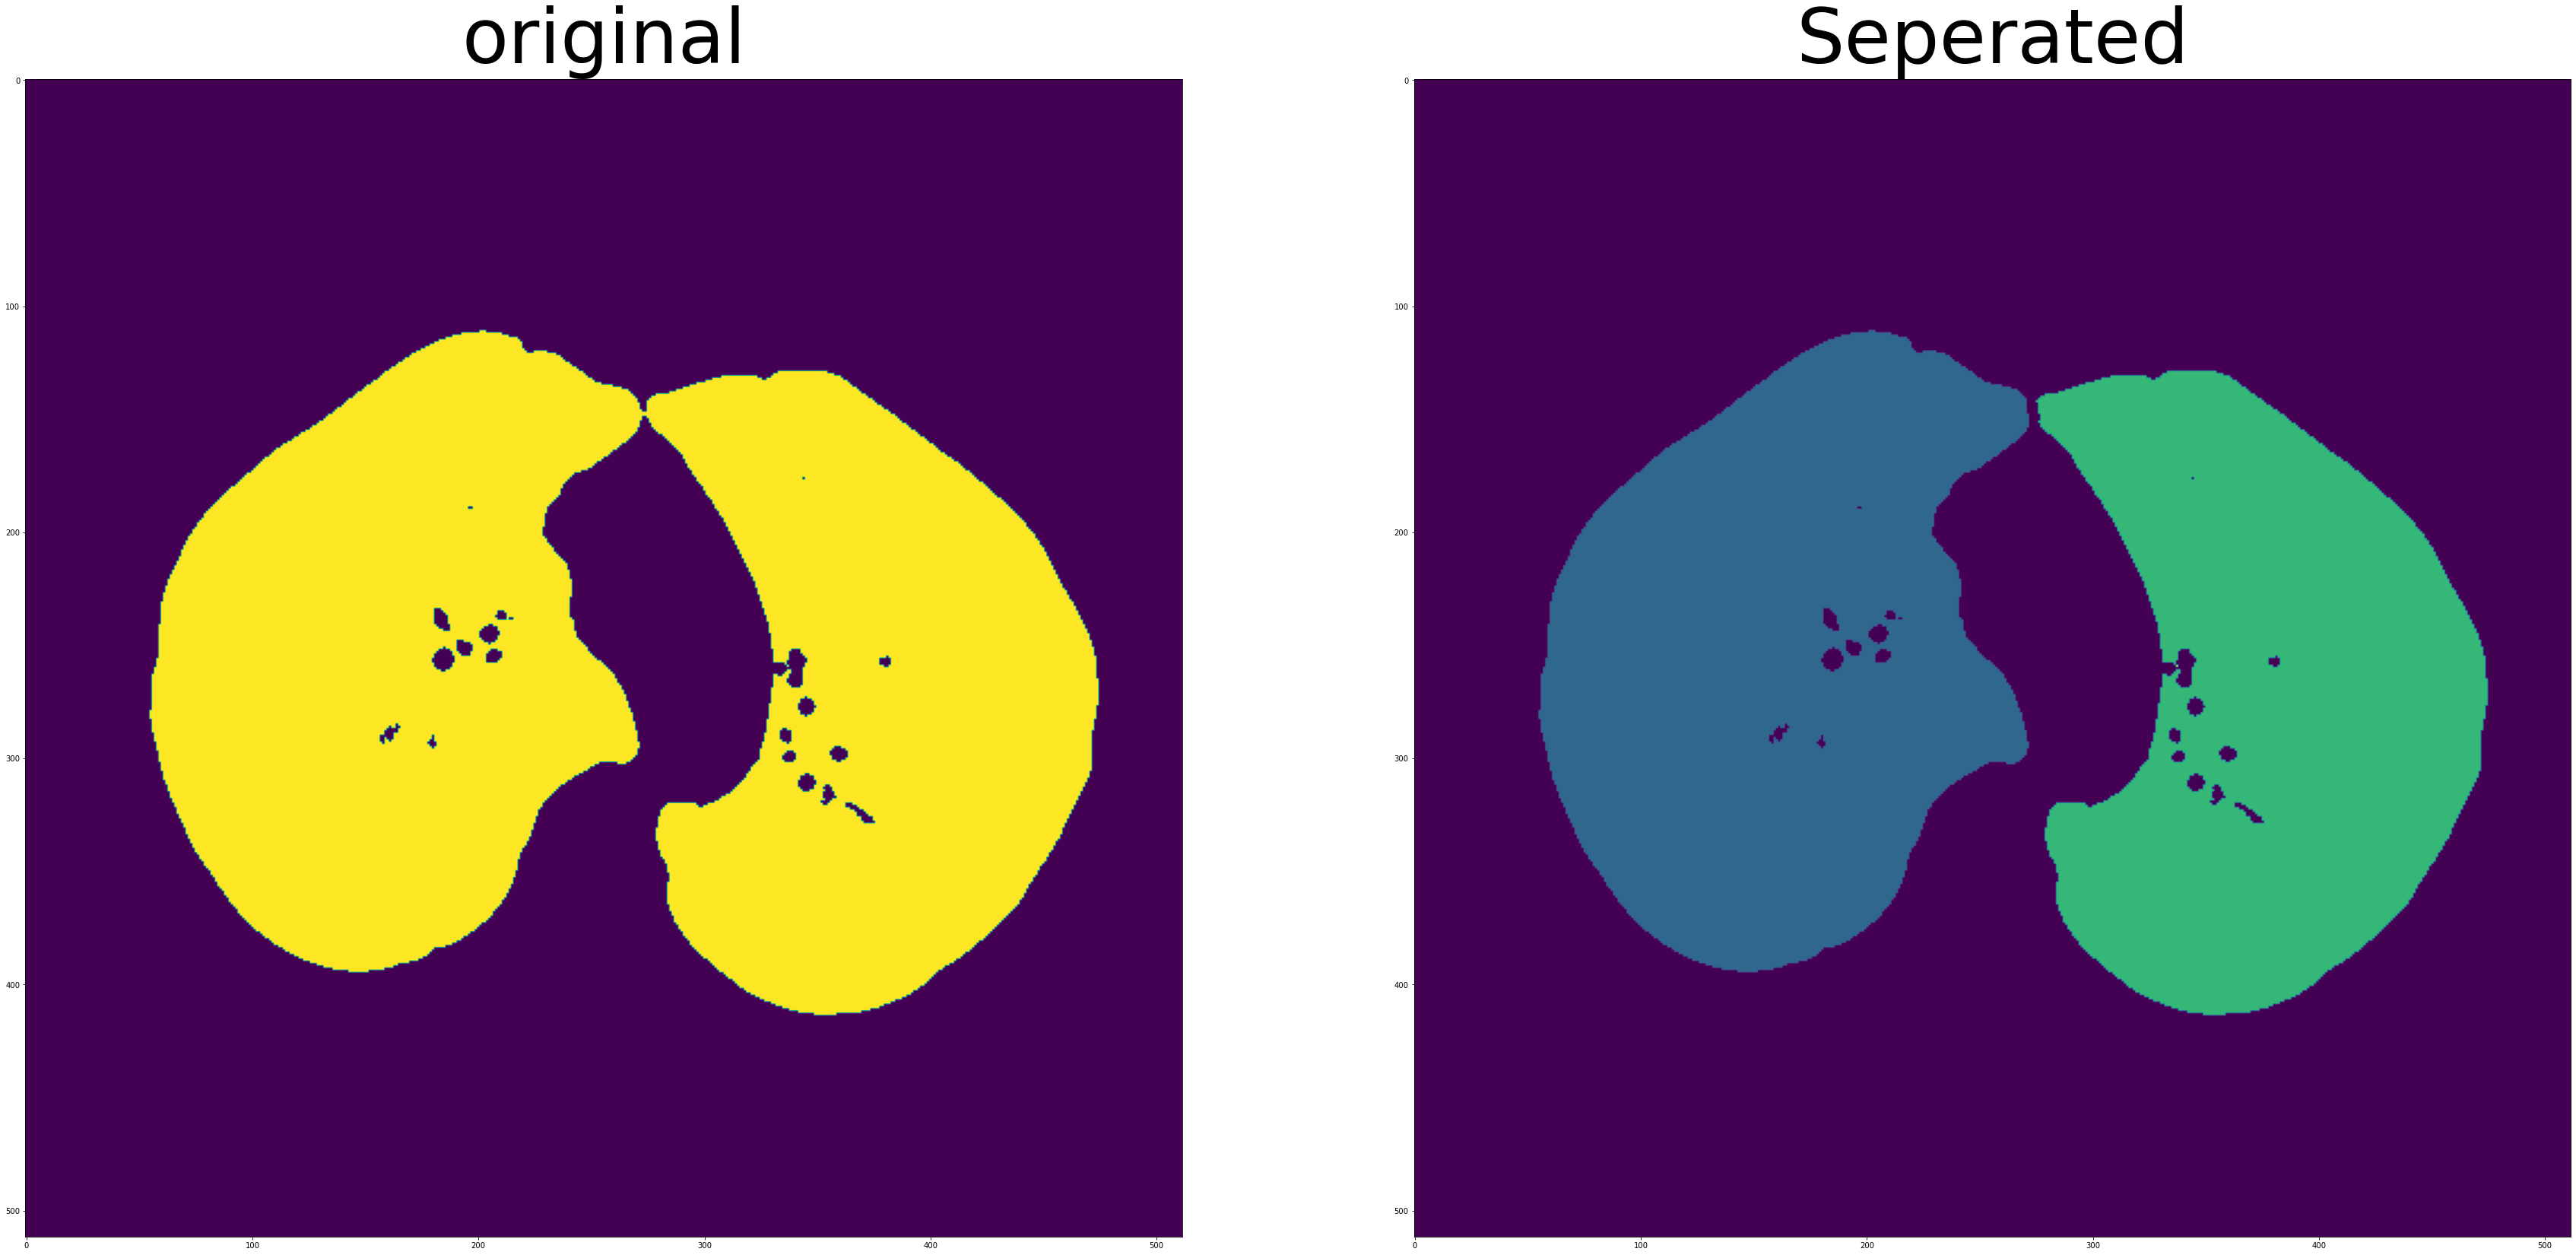

In [27]:
# Result 2, Case 1: Left right lung 'cutted' and distinguished 
img, n_comp = label(CTVol_seperated[:,:,57])
displayCompare(segmented_wo_trachea, img, s=57, title_after='Seperated')
# As we can see, the little connected part in the 'back' region of lung is removed in second pic

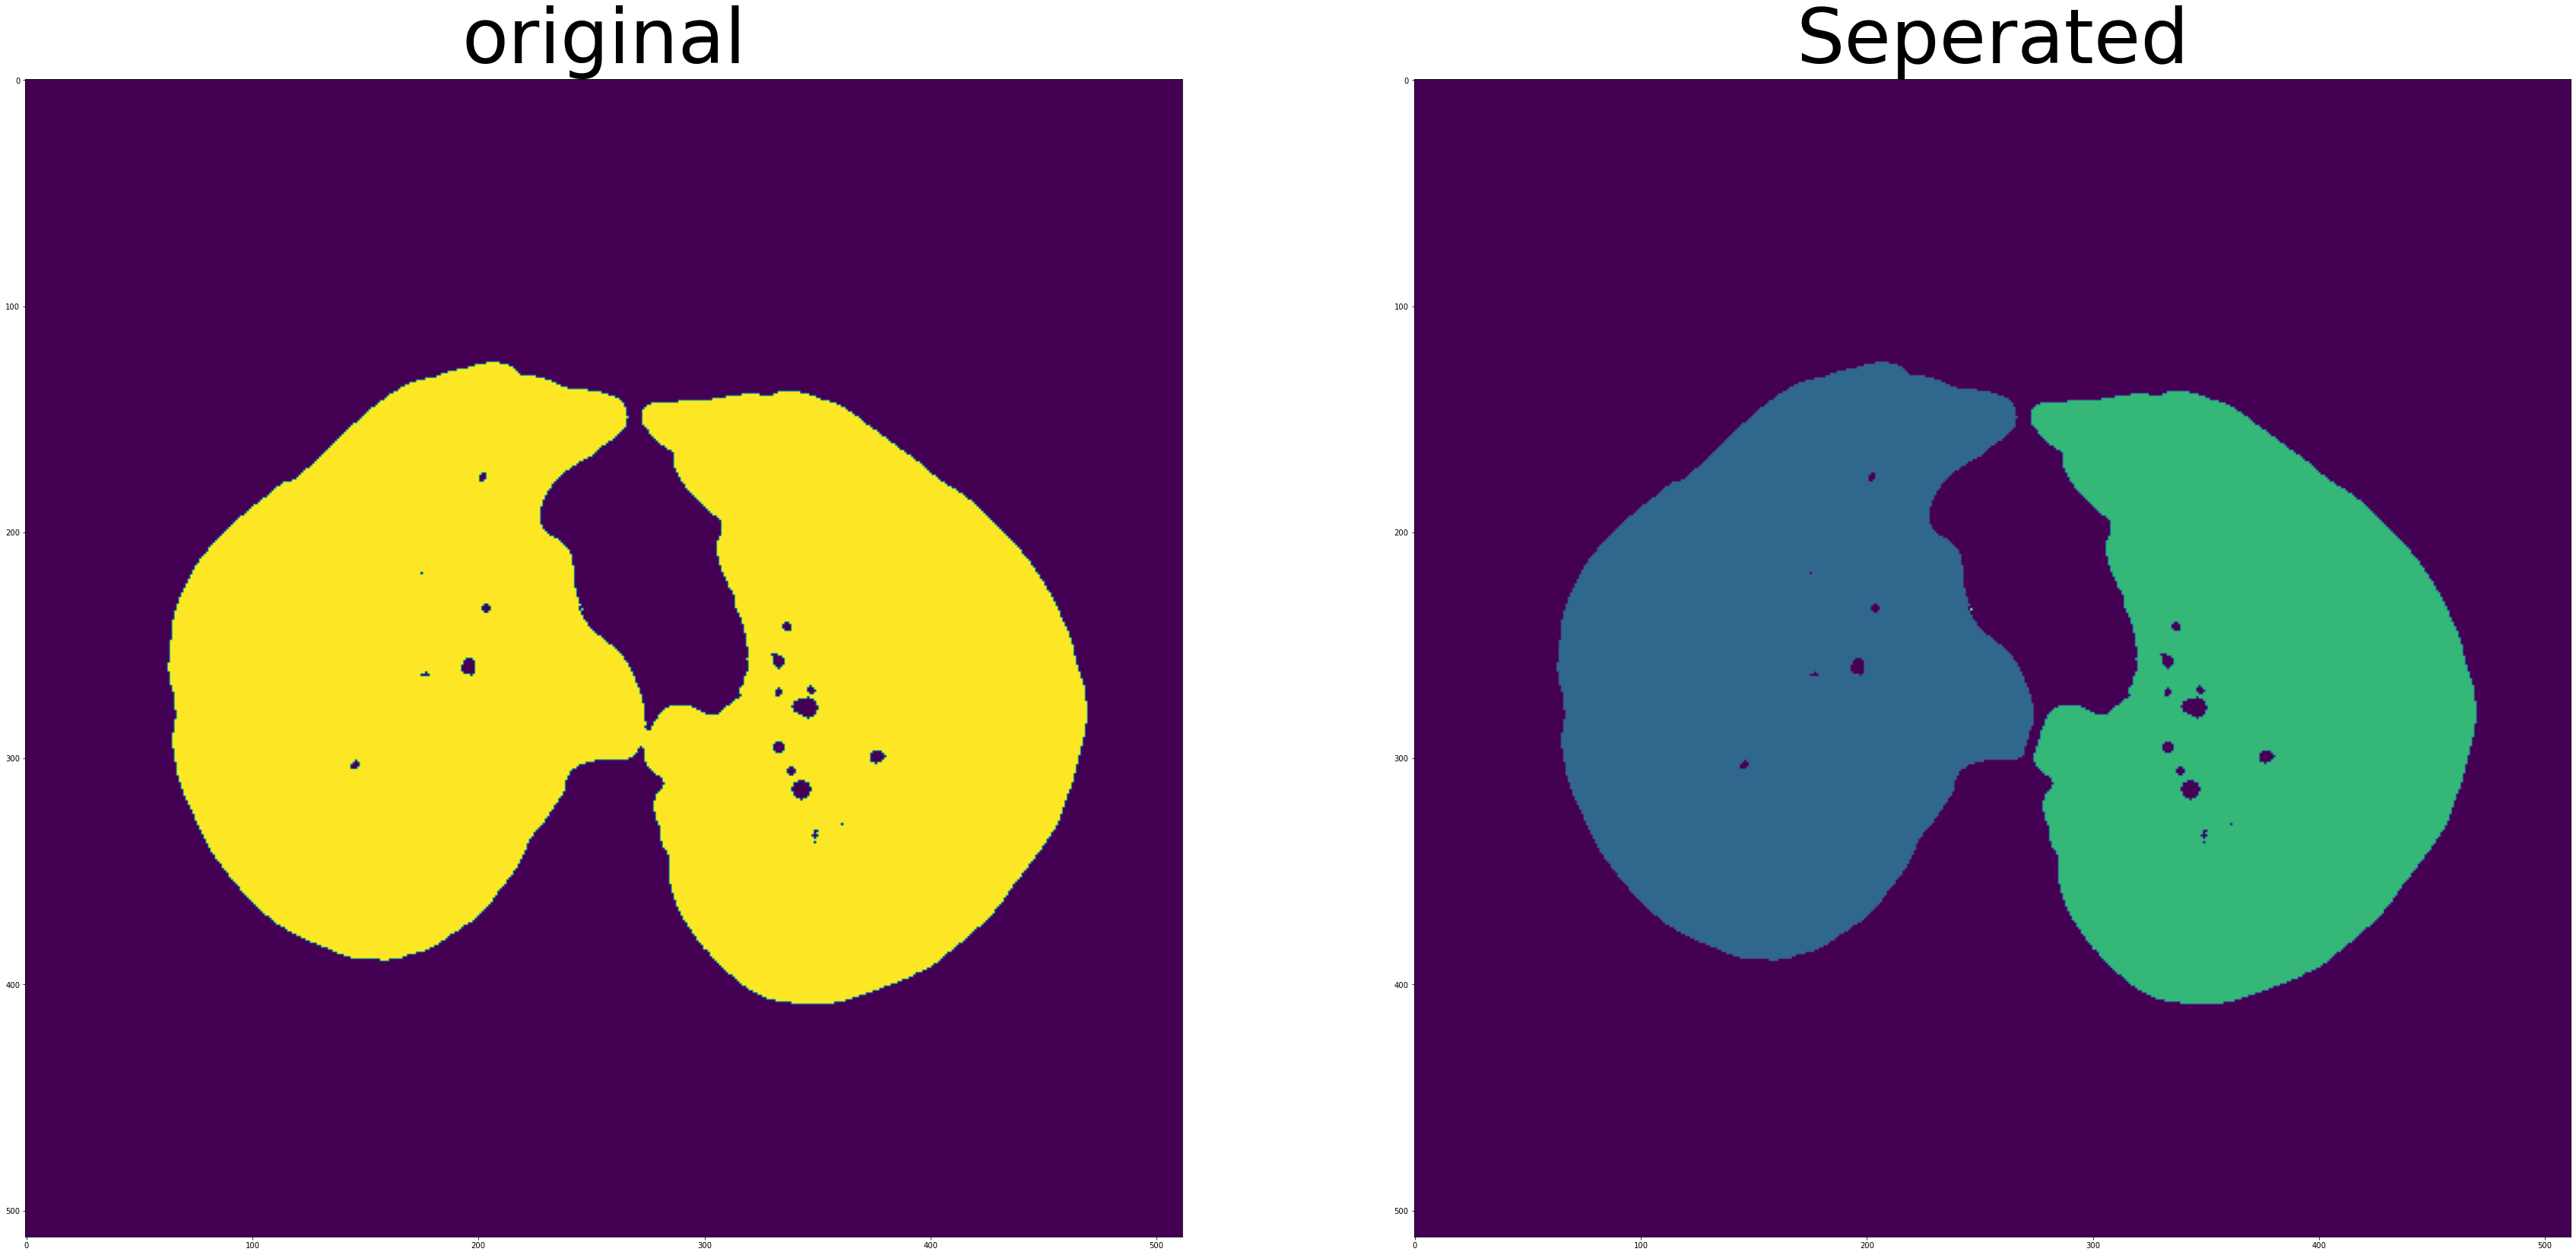

In [28]:
# Result 2, Case 2: Left right lung 'cutted' and distinguished 
img, n_comp = label(CTVol_seperated[:,:,50])
displayCompare(segmented_wo_trachea, img, s=50, title_after='Seperated')
# Another case where the connection is at the 'front' part of the lung.

In [29]:
# Results for scan_num = 10
CTVol_hu2 = preprocessing(10, nor=False)
segmented2 = segmentation(10, display=False)
segmented_wo_trachea2 = removeTrachea(CTVol_hu2, segmented2)
CTVol_seperated2 = seperateLung(segmented_wo_trachea2)

/Users/terryli/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in long_scalars
/Users/terryli/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: overflow encountered in long_scalars
/Users/terryli/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: overflow encountered in long_scalars


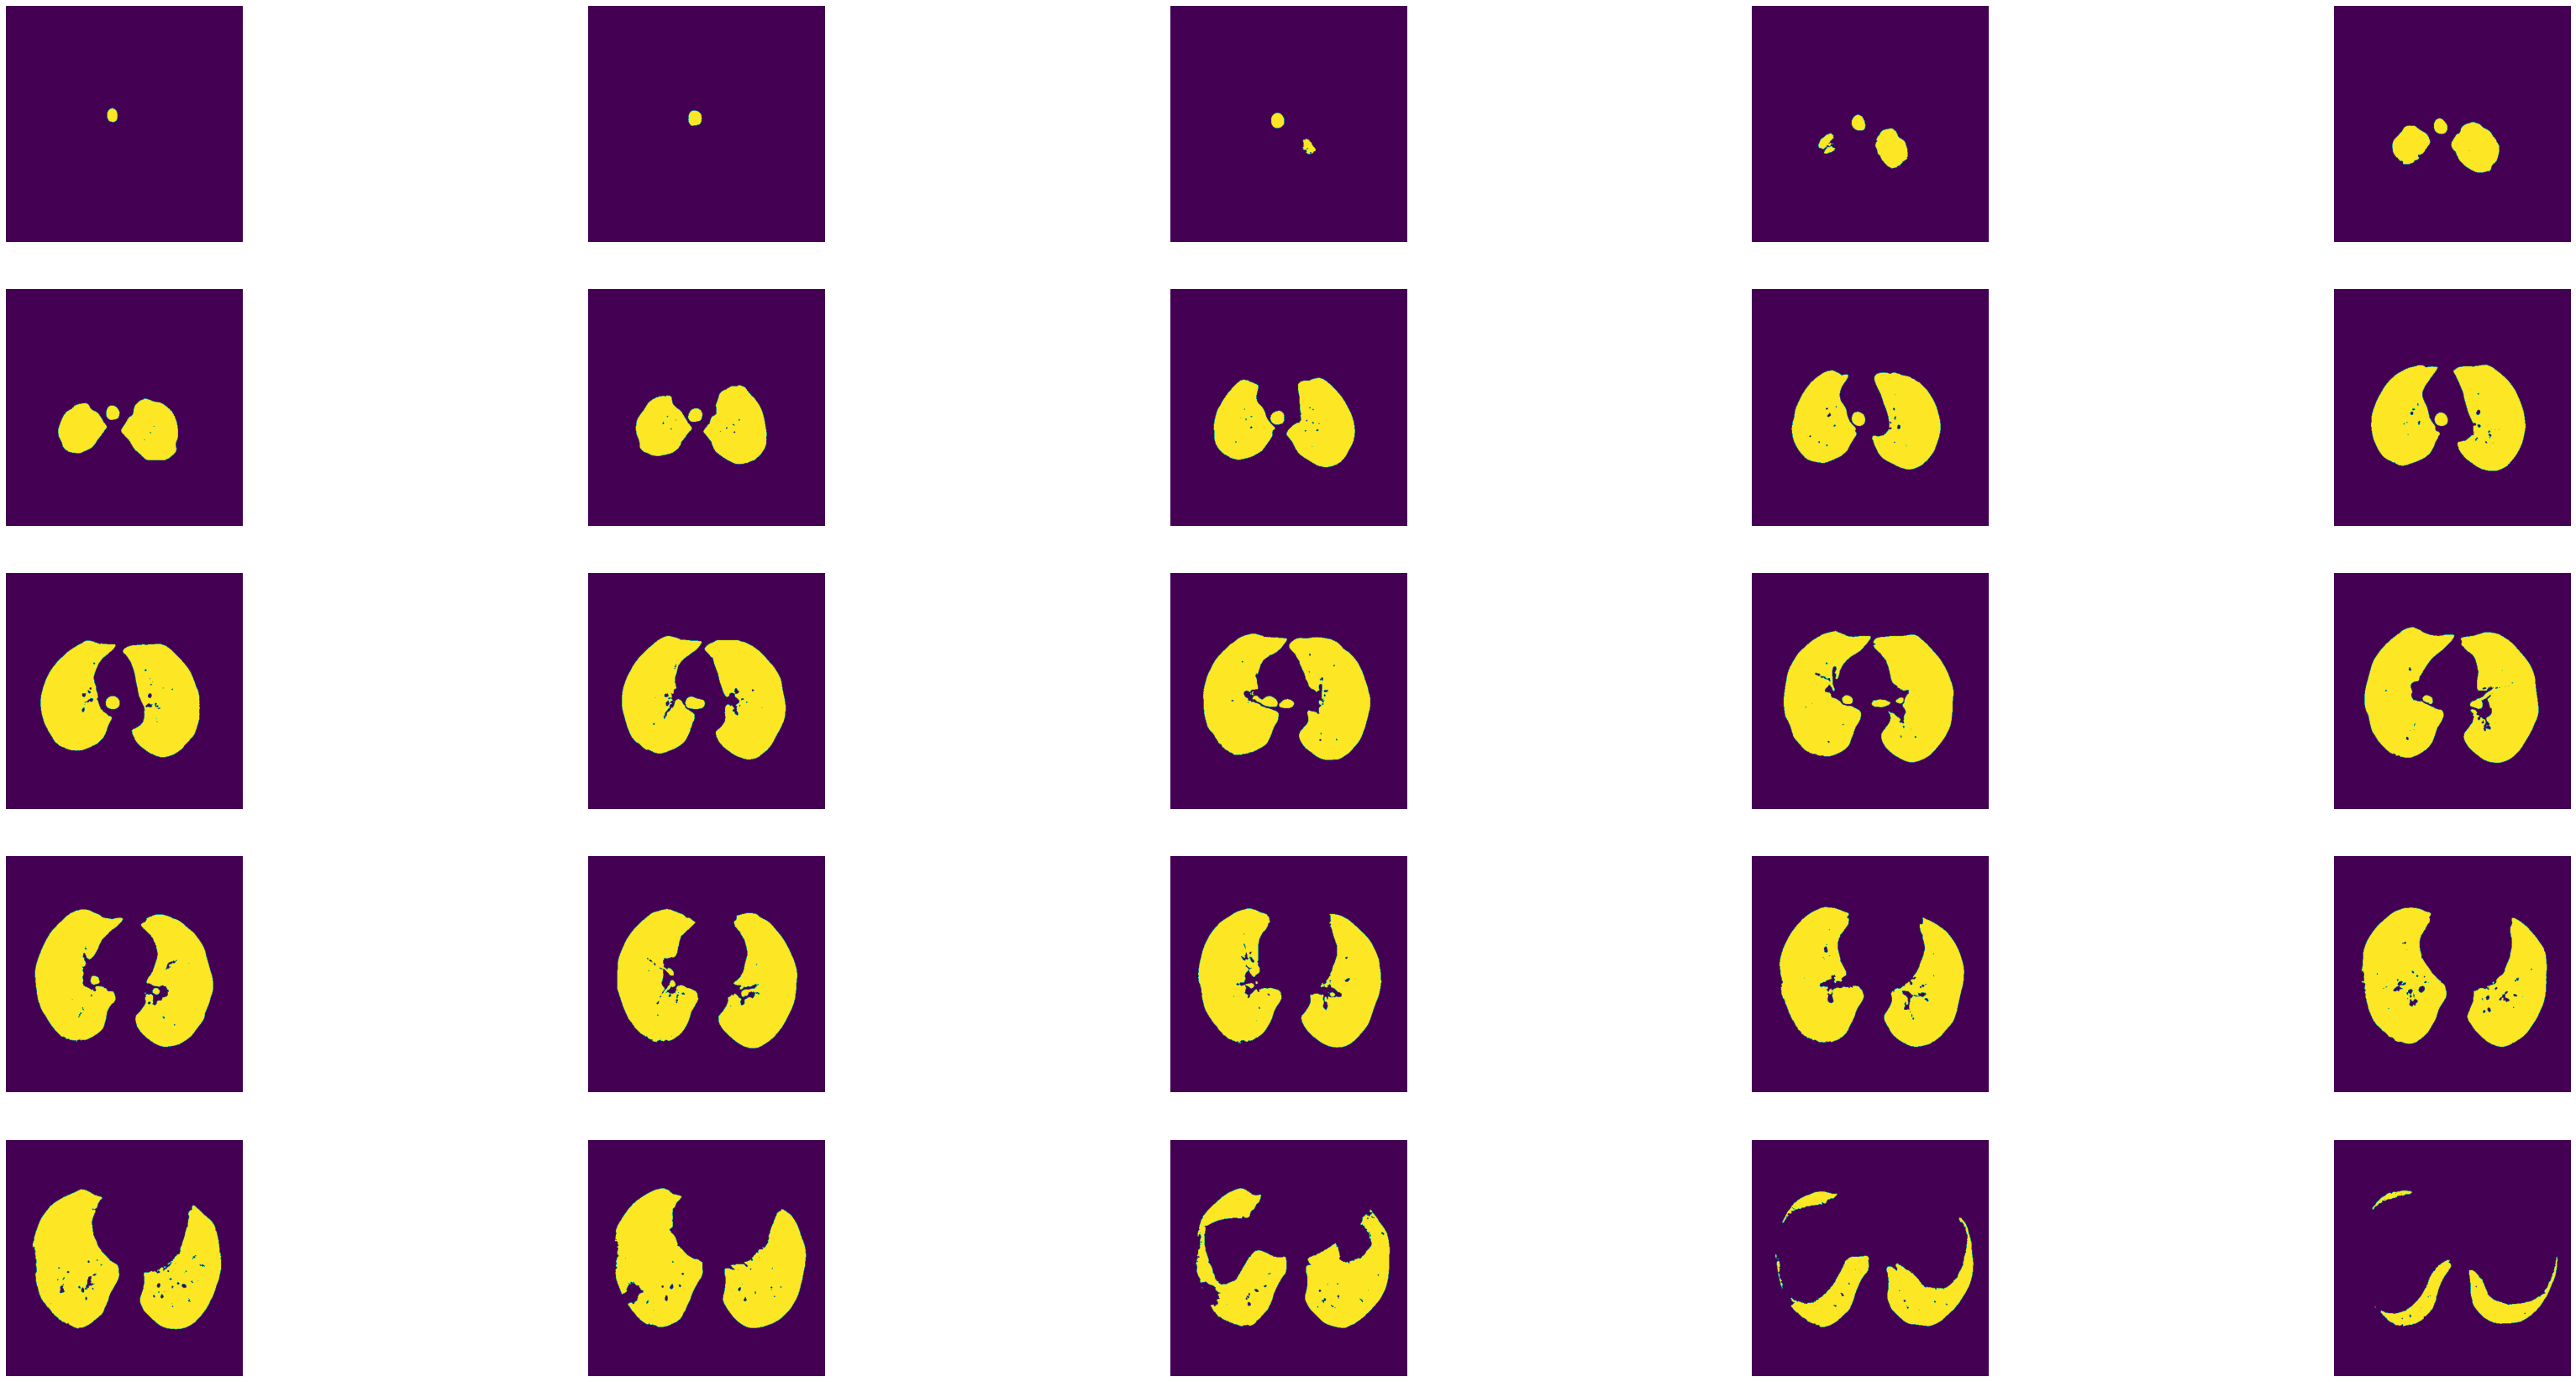

In [30]:
# Result 0: Segmentation
display25(segmented2)

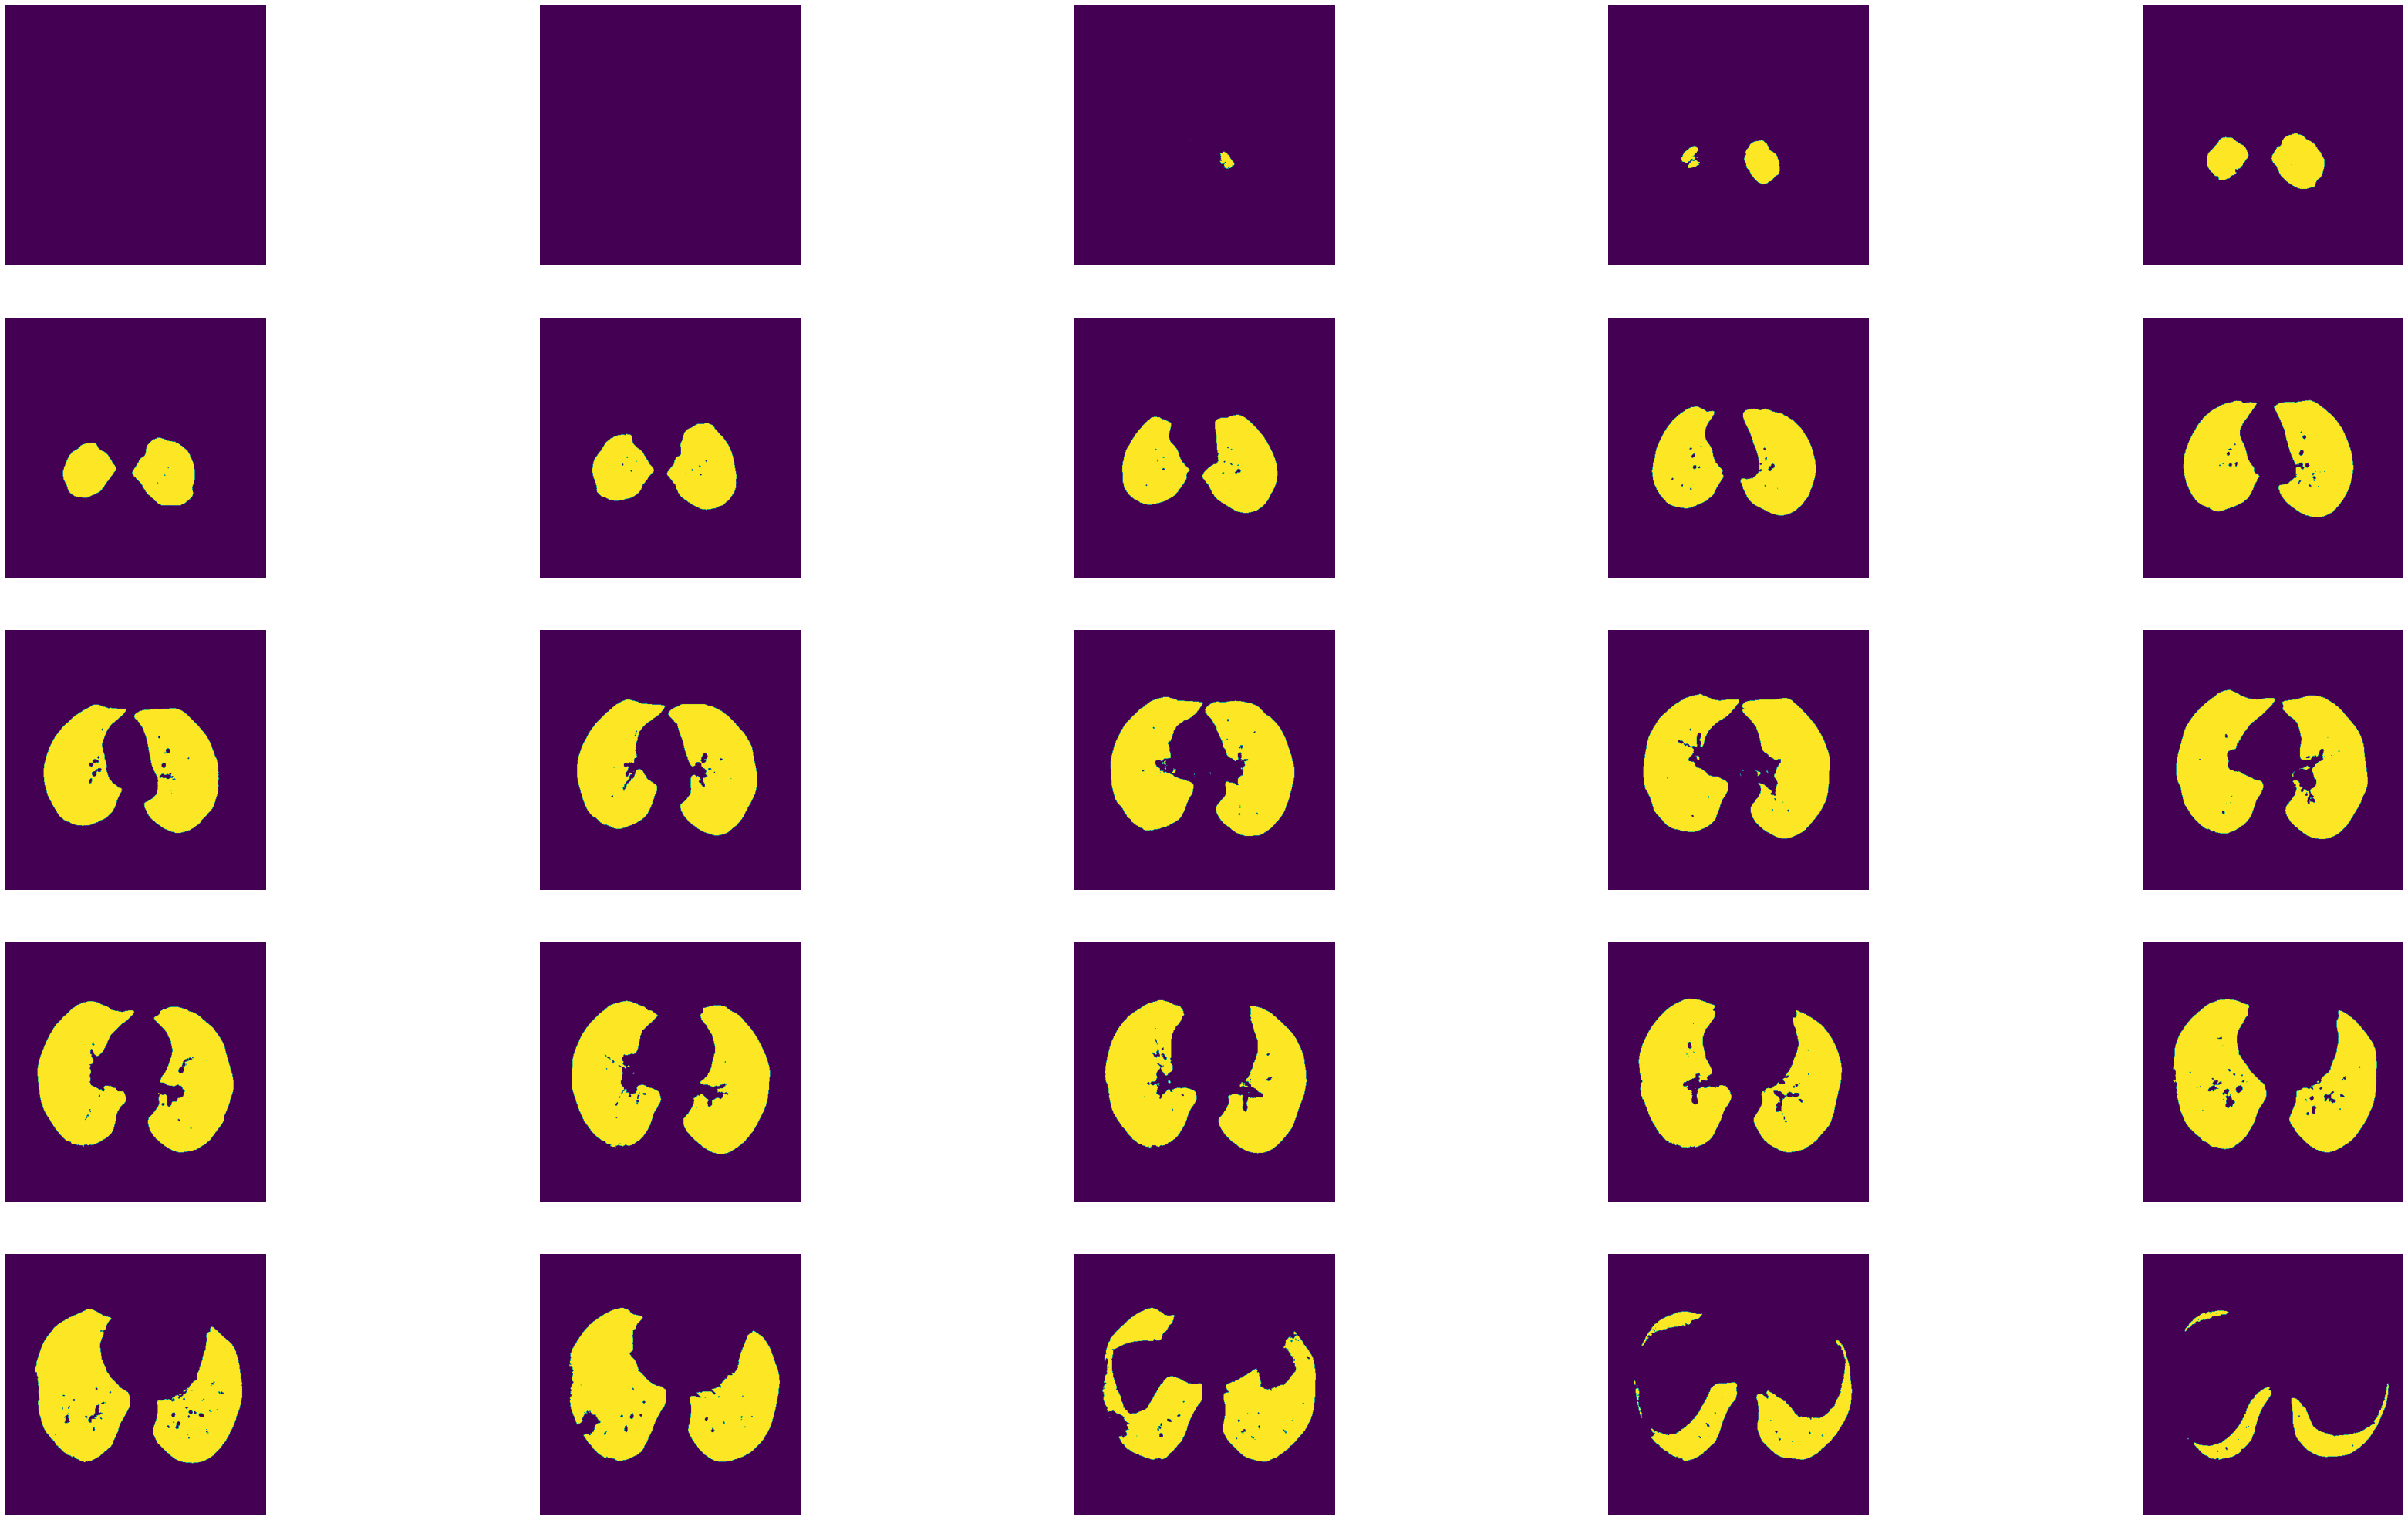

In [31]:
# Result 1: removed trachea
display25(segmented_wo_trachea2)

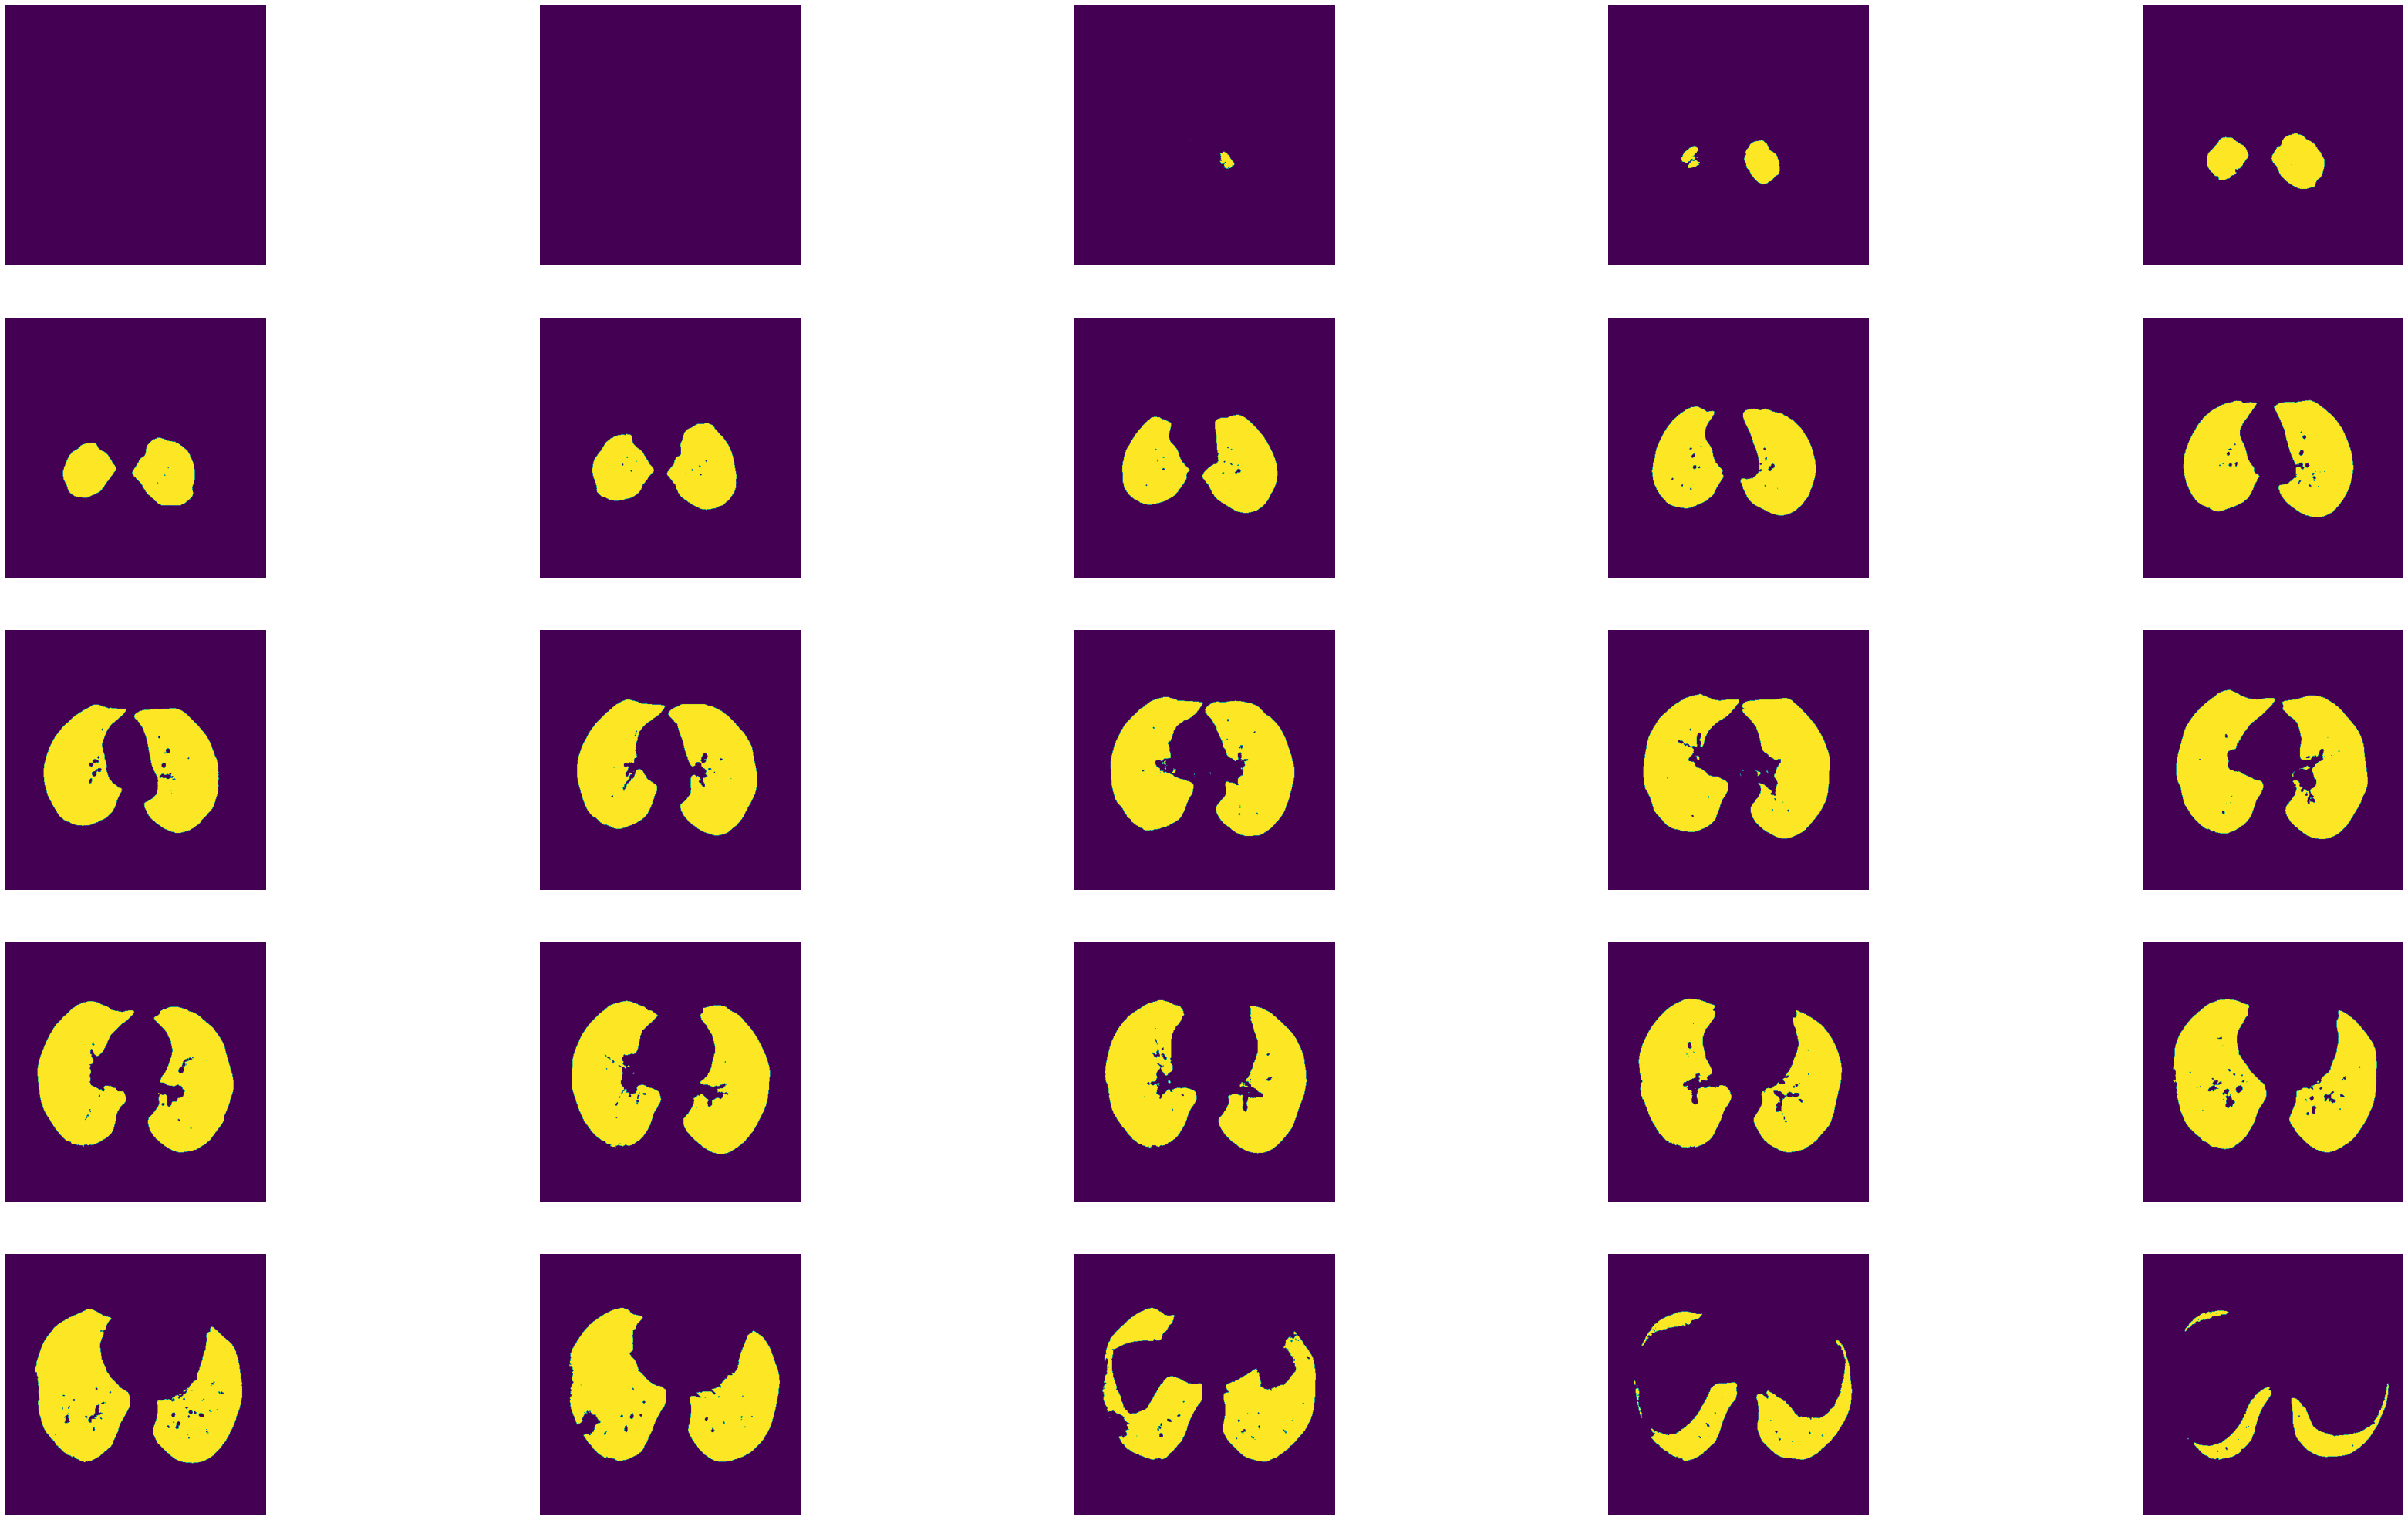

In [32]:
# Result 2: seperation
display25(CTVol_seperated2)

## References

[Correcting Non-Uniform Illumination - Rice Image](https://www.mathworks.com/cmsimages/97744_wm_correcting-nonuniform-illumination.jpg)

[Segmentation - Brain Image](http://www.bioclinica.com/sites/default/files/u1/atlas-based-brain-segmentation-lg.jpg)

We thank Darvin Yi for the content.